In [13]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import requests
import cv2 
from numpy.polynomial import Polynomial
from skimage.morphology import skeletonize, binary_closing, square, binary_erosion, binary_dilation, medial_axis, thin, disk, convex_hull_image, diamond, star, isotropic_closing, remove_small_objects
from skimage.filters import threshold_otsu
import json

In [14]:
seconds = 2313
sem_segm_img_path = f"/Users/senneloobuyck/Documents/Thesis_project/04_matching/main_7/picked_masks/2023_RVV_1_mask_{str(seconds)}.jpg"
mapbox_imgs_dir_path = f"/Users/senneloobuyck/Documents/Thesis_project/04_matching/main_7/mapbox_method_no_stitching/mapbox_images_for_frame_{str(seconds)}_RVV1"
heli_lat = 50.844850
heli_lon = 3.643452
altitude = 154.64

In [15]:
def plot_image(img):
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [16]:
def plot_patch(img, center_pixel, patch_size) : 
    # Calculate the patch boundaries
    top = center_pixel[0] - patch_size // 2
    bottom = top + patch_size
    left = center_pixel[1] - patch_size // 2
    right = left + patch_size

    # Ensure the patch boundaries stay within the image dimensions
    if top < 0:
        top = 0
    if bottom > img.shape[0]:
        bottom = img.shape[0]
    if left < 0:
        left = 0
    if right > img.shape[1]:
        right = img.shape[1]

    # Extract the patch from the image
    patch = img[top:bottom, left:right]

    # Plot the patch
    plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))  # Assuming the image is grayscale
    plt.axis('off')  # Hide axes
    plt.show()

In [17]:
def calculate_bearing(lat1, long1, lat2, long2) : 
    lat1 = math.radians(lat1)
    long1 = math.radians(long1)
    lat2 = math.radians(lat2)
    long2 = math.radians(long2)

    d_long = long2 - long1

    y = math.sin(d_long) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_long)

    brng = math.atan2(y, x)

    brng = math.degrees(brng)
    brng = (brng + 360) % 360
    # brng = 360 - brng # count degrees clockwise - remove to make counter-clockwise
    return brng

In [18]:
def haversine(lat1, lon1, lat2, lon2) : 
    R = 6371
    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    a = math.sin(d_lat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c * 1000
    return d

In [19]:
# calculate pitch/tilt
def calculate_pitch(heli_lat, heli_lon, intersec_lat, intersec_lon, alt) : 
    dist = haversine(heli_lat, heli_lon, intersec_lat, intersec_lon)

    # result = heli_df[(heli_df['lat'] == heli_lat) & (heli_df['lng'] == heli_lon)]
    # if not result.empty:
    #    altitude = result.iloc[0]['alt']

    print(f"Distance: {dist}")
    print(f"Altitude: {alt}")

    alpha_radian = math.atan2(alt, dist)
    alpha_degrees = alpha_radian * (180.0 / math.pi)
    pitch = 90 - alpha_degrees
    return pitch 

In [20]:
def get_mapbox_intersection_image(lat, lon, bearing, tilt, seconds) : 
    if tilt > 60 :
        tilt = 60
    zoom = 18
    width = 512
    height = 512
    access_token = "pk.eyJ1Ijoic2VubmVsb29idXljayIsImEiOiJjbG1zeDVreHowZmw5Mm1xY2lxeTFtYTB2In0.ymj-xZAfeeivbksi1PJttw" 
    styles_url = "mapbox://styles/senneloobuyck/cllcojw8d00wy01pb6rqcdmm5"

    style_code = styles_url.split('/')[-1]

    url = f"https://api.mapbox.com/styles/v1/senneloobuyck/{style_code}/static/{str(lon)},{str(lat)},{str(zoom)},{str(bearing)},{str(tilt)}/{str(width)}x{str(height)}?access_token={access_token}"

    response = requests.get(url)

    if not os.path.exists(f"./mapbox_images_for_frame_{seconds}_RVV1"):
        os.makedirs(f"./mapbox_images_for_frame_{seconds}_RVV1")

    img_path = f"./mapbox_images_for_frame_{seconds}_RVV1/{lat}_{lon}.jpg"

    if response.status_code == 200:
        with open(img_path, "wb") as f:
            f.write(response.content)
        print(f"Image saved as {lat}_{lon}.jpg")
    else:
        print("Failed to retrieve image for intersection lat = " + str(lat) + ", lon = " + str(lon))
        print(response.text[:100])

In [21]:
def get_intersection_coordinates(lat, lon) : 
    # some lists and dataframes to store the data
    nodes = []
    intersection_nodes = []
    df_nodes = pd.DataFrame(columns=['id', 'lat', 'lon'])
    df_intersections = pd.DataFrame(columns=['lat', 'lon'])

    overpass_url = "http://overpass-api.de/api/interpreter"


    # first get the ways around the point 
    # .w is a temporary variable that stores the result of the first query
    # node(way_cnt:2-);   // select those nodes that are members of two or more of the given ways
    overpass_query = f"""[out:json];
                        way(around: 300, {lat},{lon})["highway"~"(motorway|trunk|primary|secondary|tertiary|unclassified|residential|motorway_link|trunk_link|primary_link|secondary_link|tertiary_link|living_street|service|pedestrian)"]->.w;
                        node(way_cnt.w:2-);  
                        out;"""

    response = requests.get(overpass_url, params={'data': overpass_query})

    # print(response.json()['elements'])

    for item in response.json()['elements']:
        df_intersections.loc[len(df_intersections)] = {'lat': item['lat'], 'lon': item['lon']}


    # print(df_intersections)
    return df_intersections

In [22]:
df_intersections = get_intersection_coordinates(heli_lat, heli_lon)

# read in csv file with heli coordinates
heli_path = "/Users/senneloobuyck/Documents/Thesis_project/01_inputs/csv-files/2023 Ronde van Vlaanderen 1 heli.csv"
heli_df = pd.read_csv(heli_path)
heli_df['lat'] = heli_df.apply(lambda row: float(row['lat']) * 1 if row['NS'] == 'N' else float(row['lat']) * (-1), axis=1)
heli_df['lng'] = heli_df.apply(lambda row: float(row['lng']) * 1 if row['EW'] == 'E' else float(row['lng']) * (-1), axis=1)
heli_df = heli_df[['lat', 'lng', 'alt', 'seconds_from_start']]

for index, row in df_intersections.iterrows() : 
    print(f"Intersection: {row['lat']},{row['lon']}")
    bearing = calculate_bearing(heli_lat, heli_lon, row['lat'], row['lon'])
    print(f"Bearing = {bearing}")
    pitch = calculate_pitch(heli_lat, heli_lon, row['lat'], row['lon'], alt=altitude)
    print(f"Pitch = {pitch}")
    # get_mapbox_intersection_image(row['lat'], row['lon'], bearing, pitch, seconds)

Intersection: 50.8433633,3.6459059
Bearing = 133.81463667468654
Distance: 238.77518809789586
Altitude: 154.64
Pitch = 57.07135292820075
Intersection: 50.8455099,3.6426846
Bearing = 323.71127026393174
Distance: 91.03441817730669
Altitude: 154.64
Pitch = 30.484730407225605
Intersection: 50.8465495,3.6435285
Bearing = 1.6279843571326182
Distance: 189.0520899109949
Altitude: 154.64
Pitch = 50.717670809756726
Intersection: 50.8431527,3.6440709
Bearing = 167.03367514678416
Distance: 193.66912100188839
Altitude: 154.64
Pitch = 51.39350069980947
Intersection: 50.8433055,3.6459965
Bearing = 133.86856286390787
Distance: 247.81516479397592
Altitude: 154.64
Pitch = 58.03528144090792


In [23]:
def get_skeleton(mask_bgr, contour) : 
    print("Getting the skeleton")

    mask_gray = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2GRAY)

    # draw contour in white on black background
    contour_mask_gray = np.zeros_like(mask_gray)
    cv2.drawContours(contour_mask_gray, [contour], -1, 255, -1)

    ret, contour_mask_thresh_gray = cv2.threshold(contour_mask_gray, 127, 255, cv2.THRESH_BINARY)
    contour_mask_thresh_bgr = cv2.cvtColor(contour_mask_thresh_gray, cv2.COLOR_GRAY2BGR)
    # plot_image(contour_mask_thresh_bgr)

    
    # To avoid the precision loss when converting the image to bool, 
    # you can also binarize the image using one of the available thresholding algorithms
    thresh_otsu = threshold_otsu(contour_mask_thresh_gray)
    contour_mask_thresh_gray = contour_mask_thresh_gray > thresh_otsu
    
    # skeletonize
    # skeleton_gray = (skeletonize(contour_mask_gray)).astype(np.uint8)
    skeleton_gray = skeletonize(contour_mask_thresh_gray, method='lee').astype(np.uint8)

    # np.set_printoptions(threshold=np.inf)
    # print("Skeleton image values:")
    # print(skeleton_gray)


    # plt.figure(figsize=(20,10))
    # plt.imshow(skeleton_gray, cmap='gray', interpolation='nearest')
    # plt.show()

    skeleton_bgr = cv2.cvtColor(skeleton_gray, cv2.COLOR_GRAY2BGR)

    return skeleton_bgr
            

In [24]:
def is_valid_intersection(neighbourhood_patch) : 
    # A list of valid intersections             
    # These are in the format (clockwise order)
    # 2 3 4
    # 1 C 5
    # 8 7 6 
    validIntersection = [[0,1,0,1,0,0,1,0],[0,0,1,0,1,0,0,1],[1,0,0,1,0,1,0,0],
                         [0,1,0,0,1,0,1,0],[0,0,1,0,0,1,0,1],[1,0,0,1,0,0,1,0],
                         [0,1,0,0,1,0,0,1],[1,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,1],
                         [0,1,0,1,0,0,0,1],[0,1,0,1,0,1,0,0],[0,0,0,1,0,1,0,1],
                         [1,0,1,0,0,0,1,0],[1,0,1,0,1,0,0,0],[0,0,1,0,1,0,1,0],
                         [1,0,0,0,1,0,1,0],[1,0,0,1,1,1,0,0],[0,0,1,0,0,1,1,1],
                         [1,1,0,0,1,0,0,1],[0,1,1,1,0,0,1,0],[1,0,1,1,0,0,1,0],
                         [1,0,1,0,0,1,1,0],[1,0,1,1,0,1,1,0],[0,1,1,0,1,0,1,1],
                         [1,1,0,1,1,0,1,0],[1,1,0,0,1,0,1,0],[0,1,1,0,1,0,1,0],
                         [0,0,1,0,1,0,1,1],[1,0,0,1,1,0,1,0],[1,0,1,0,1,1,0,1],
                         [1,0,1,0,1,1,0,0],[1,0,1,0,1,0,0,1],[0,1,0,0,1,0,1,1],
                         [0,1,1,0,1,0,0,1],[1,1,0,1,0,0,1,0],[0,1,0,1,1,0,1,0],
                         [0,0,1,0,1,1,0,1],[1,0,1,0,0,1,0,1],[1,0,0,1,0,1,1,0],
                         [1,0,1,1,0,1,0,0]]
    
    if neighbourhood_patch in validIntersection : 
        return True
    else : 
        return False

In [25]:
def get_skeleton_intersection(skeleton):
    """ Given a skeletonised image, it will give the coordinates of the intersections of the skeleton"""
    print("Getting intersections in skeleton (more than 2 neighbours)")
    skeleton_gray = cv2.cvtColor(skeleton, cv2.COLOR_BGR2GRAY)
    image = skeleton_gray.copy()
    image = image/255
    intersections = []
    for y in range(1,len(image)-1):
        for x in range(1,len(image[y])-1):
            # if we have a white pixel
            if image[y][x] == 1:
                neighbourhood_patch = [image[y][x-1], image[y-1][x-1], image[y-1][x], image[y-1][x+1], image[y][x+1], image[y+1][x+1], image[y+1][x], image[y+1][x-1]]
                if is_valid_intersection(neighbourhood_patch):
                    intersections.append((y,x))
    # Filter intersections to make sure we don't count them twice or ones that are very close together
    # for point1 in intersections:
    #     for point2 in intersections:
    #         if (((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2) and (point1 != point2):
    #             intersections.remove(point2)
    # Remove duplicates
    return intersections


In [26]:
def get_neighbour_pixels(skel_contour_bgr, intersec) : 
    
    # print(f"Getting neighbour pixels for pixel {intersec}")
    
    skel_contour_bgr_copy = skel_contour_bgr.copy()
    
    # converting to grayscale gives false values
    # skel_contour_gray = cv2.cvtColor(skel_contour_bgr, cv2.COLOR_BGR2GRAY)

    # plot_patch(skel_contour_bgr_copy, intersec, 7)


    # Calculate neighbour pixels that define the roads that intersect (in patch values)
    road_neighbour_pixels = []
    for x in range(-1,2):
        for y in range(-1,2):
            pixel_color = skel_contour_bgr[intersec[0] + y, intersec[1] + x]
            # print(f"Pixel color = {pixel_color}")
            if np.all(pixel_color == np.array([255, 255, 255])) and (x != 0 or y != 0):
                road_neighbour_pixels.append((intersec[0]+y, intersec[1]+x))
                skel_contour_bgr_copy[intersec[0]+y, intersec[1]+x] = (0,0,255)
                # print(f"Neighbour pixel for pixel {intersec} within image: {intersec[0]+y}, {intersec[1]+x}")

    # plot_patch(skel_contour_bgr_copy, intersec, 7)

    return road_neighbour_pixels

In [27]:
def get_descriptors(skeleton_bgr, intersections, visualize=False) : 
    skeleton_gray = cv2.cvtColor(skeleton_bgr, cv2.COLOR_BGR2GRAY)

    dict_angles = {}
    dict_other_intersecs = {}
    descriptors = []

    skeleton_gray = cv2.cvtColor(skeleton_bgr, cv2.COLOR_BGR2GRAY)
    image = skeleton_gray.copy()
    image = image/255

    for intersection_pixel in intersections :
        dict_angles[intersection_pixel] = []
        dict_other_intersecs[intersection_pixel] = []
        # print(f"Getting neighbour pixels for intersection pixel {intersection_pixel}")
        neighbour_road_pixels = get_neighbour_pixels(skeleton_bgr, intersection_pixel)
        # print(f"Neighbour pixels: {neighbour_road_pixels}")

        for neighbour_pixel in neighbour_road_pixels :
            try : 
                processed_pixels = [intersection_pixel] + neighbour_road_pixels
                road_pixels = []
                end_for_intersec_neighbour_pixel = False
                reference_pixel = neighbour_pixel
                count = 0
                count_treshold = 12
                skip_count_threshold = 2
                
                while count < count_treshold :
                    # print(f"Getting new neighbour pixels for reference pixel {reference_pixel}")
                    new_neighbour_pixels = get_neighbour_pixels(skeleton_bgr, reference_pixel)
                    # print(f"New neighbour pixels: {new_neighbour_pixels}")


                    new_neighbours_not_processed = [pixel for pixel in new_neighbour_pixels if pixel not in processed_pixels]
                    if len(new_neighbours_not_processed) > 0 :
                        new_neighbour_pixel = new_neighbours_not_processed[0]
                        y, x = new_neighbour_pixel
                        new_neighbour_patch = [image[y][x-1], image[y-1][x-1], image[y-1][x], image[y-1][x+1], image[y][x+1], image[y+1][x+1], image[y+1][x], image[y+1][x-1]]
                        if is_valid_intersection(new_neighbour_patch) : 
                            # print(f"New neighbour pixel: {new_neighbour_pixel} is a valid intersection, end for this intersection pixel")
                            dict_other_intersecs[intersection_pixel].append(new_neighbour_pixel)
                            end_for_intersec_neighbour_pixel = True
                            break
                        else : 
                            processed_pixels.append(new_neighbour_pixel)
                            reference_pixel = new_neighbour_pixel

                        if count >= skip_count_threshold : 
                            if count == skip_count_threshold :
                                # print("Skip count threshold reached")
                                first_road_pixel = new_neighbour_pixel
                            if count == skip_count_threshold + 1 : 
                                second_road_pixel = new_neighbour_pixel
                            road_pixels.append(new_neighbour_pixel)
                    else : 
                        # print("No new neighbour pixels found, end for this intersection pixel")
                        end_for_intersec_neighbour_pixel = True
                        break
                    
                    if end_for_intersec_neighbour_pixel is False :
                        count += 1
                    else : 
                        break
            
                if count == count_treshold :
                    # print("Count threshold reached")

                    skeleton_bgr_copy = skeleton_bgr.copy()

                    skeleton_bgr_copy[first_road_pixel[0], first_road_pixel[1]] = [0,0,255]
                    skeleton_bgr_copy[second_road_pixel[0], second_road_pixel[1]] = [0,255,0]
                    # all the other road pixels in blue 
                    for pixel in road_pixels :
                        if pixel != first_road_pixel and pixel != second_road_pixel :
                            skeleton_bgr_copy[pixel[0], pixel[1]] = [255,0,0]

                    
                    # plot_patch(skeleton_bgr_copy, first_road_pixel, 23)


                    # print(f"Shape of skeleton_gray: {skeleton_gray.shape}")


                    # Now use the first road pixel as origin and compute the angle of the road segment
                    # First reverse the y coordinates to make sure the origin is in the bottom left corner
                    road_pixels = [((skeleton_gray.shape[0]-1)-pixel[0], pixel[1]) for pixel in road_pixels]
                    # print(f"Road pixels: {road_pixels}")

                    first_road_pixel = ((skeleton_gray.shape[0]-1)-first_road_pixel[0], first_road_pixel[1])
                    second_road_pixel = ((skeleton_gray.shape[0]-1)-second_road_pixel[0], second_road_pixel[1])

                    # Adjust the coordinates of road pixels and intersection to be relative to the center
                    adjusted_road_pixels = [(pixel[0] - first_road_pixel[0], pixel[1] - first_road_pixel[1]) for pixel in road_pixels]
                    # print(f"Adjusted road pixels: {adjusted_road_pixels}")

                    second_road_pixel = (second_road_pixel[0] - first_road_pixel[0], second_road_pixel[1] - first_road_pixel[1])
                    first_road_pixel = (0,0)
                    # print(f"First road pixel: {first_road_pixel}")
                    # print(f"Second road pixel: {second_road_pixel}")

                    # For each set of coordinates, compute the best-fit line
                    x_values = np.array([coord[1] for coord in adjusted_road_pixels])
                    y_values = np.array([coord[0] for coord in adjusted_road_pixels])

                    positive_x_directions = 0
                    negative_x_directions = 0
                    positive_y_directions = 0
                    negative_y_directions = 0
                    for x in x_values:
                        if x > 0:
                            positive_x_directions += 1
                        elif x < 0:
                            negative_x_directions += 1
                    
                    for y in y_values:
                        if y > 0:
                            positive_y_directions += 1
                        elif y < 0:
                            negative_y_directions += 1

                    # Check if all x-values are the same
                    all_x_values_same = all(x == x_values[0] for x in x_values)
                    if all_x_values_same :
                        print("All x-values are the same")
                        if second_road_pixel[0] > first_road_pixel[0] :
                            # index 0 because y coordinate needed (index 1 is x coordinate)
                            angle = 90
                        else :
                            angle = 270
                        print(f"Angle is: {angle}")
                        dict_angles[intersection_pixel].append(angle)
                        continue

                    line = np.polyfit(x_values, y_values, deg=1)
                    
                    # print(f"Line: {line}")

                    # Now show the line on the patch
                    a = line[0]
                    b = line[1]
                    y = a * x_values + b
                    if visualize : 
                        plt.plot(x_values, y)
                        plt.show()

                    # The slope of each line gives the direction of the road segment it fits
                    angle = np.degrees(np.arctan(a))
                    # print(f"Angle: {angle}")

                    if angle == 0 and negative_x_directions > positive_x_directions :
                        angle = 180

                    if angle > 0 and negative_y_directions > positive_y_directions :
                        angle = angle + 180
                    
                    if angle < 0 :
                        if negative_y_directions < positive_y_directions :
                            angle = angle + 180
                        else : 
                            angle = angle + 360

                    print(f"Angle is: {angle}")
                    dict_angles[intersection_pixel].append(angle)
                else : 
                    print("Count threshold not reached")

            except IndexError :
                print("Index is out of bounds. Stopping the iteration.")
                continue
    

    processed_intersections = []
    for intersection in dict_other_intersecs.keys() : 
        if intersection in processed_intersections :
            continue
        # print(f"dict_other_intersecs[intersection]: ")
        # print(dict_other_intersecs[intersection])
        if len(dict_other_intersecs[intersection]) == 0 :
            descriptor = dict_angles[intersection]
            sorted_descriptor = sorted(descriptor)
            descriptors.append(sorted_descriptor)
            processed_intersections.append(intersection)
        else :
            for other_intersection in dict_other_intersecs[intersection] : 
                if other_intersection not in processed_intersections : 
                    descriptor = dict_angles[intersection] + dict_angles[other_intersection]
                    sorted_descriptor = sorted(descriptor)
                    descriptors.append(sorted_descriptor)
                    processed_intersections.append(intersection)
                    processed_intersections.append(other_intersection)
                else: 
                    continue
    
    return descriptors


In [28]:
def find_descriptors_in_segmentation_image(img_path) : 
    print("Finding descriptors in segmentation image")
    
    img_bgr = cv2.imread(img_path)
    print("Segmentation image")
    plot_image(img_bgr)

    closing_bgr = isotropic_closing(img_bgr, radius=20)
    closing_bgr = closing_bgr.astype(np.uint8) * 255
    print("Isotropic closing of segmentation image")
    plot_image(closing_bgr)

    closing_bgr_copy = closing_bgr.copy()
    mask_bgr_copy = closing_bgr.copy()
    closing_gray = cv2.cvtColor(closing_bgr, cv2.COLOR_BGR2GRAY)

    contours, hierarchy = cv2.findContours(closing_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of contours: {len(contours)}")
    cv2.drawContours(closing_bgr_copy, contours, contourIdx=-1, color=(255, 0, 0), thickness=2)

    descriptors = []

    for contour in contours :
        contour_length = cv2.arcLength(contour, closed=True)
        print(f"Contour length: {contour_length}")
        contour_area = cv2.contourArea(contour)
        print(f"Contour area: {contour_area}")

        # measure the irregularity of the polygon
        if contour_length != 0 :
            convex_hull = cv2.convexHull(contour)
            convex_hull_area = cv2.contourArea(convex_hull)
            print(f"Convex hull area: {convex_hull_area}")
            # cv2.polylines(mask_bgr_copy, [convex_hull], isClosed=True, color=(0, 255, 0), thickness=3)
            solidity = contour_area / convex_hull_area

            # get skeleton of the contour
            skeleton_contour_bgr = get_skeleton(mask_bgr_copy, contour)
            
            # find the intersections in the skeleton
            skel_intersections = get_skeleton_intersection(skeleton_contour_bgr)

            print(f"Skeleton intersections = {skel_intersections}")
            


            #  make a decision based on the solidity
            if solidity > 0.60 and skel_intersections == [] :
                print(f"Solidity = {solidity} -> no intersection in this contour")
            else :
                print(f"Solidity = {solidity} -> this contour can be related to an intersection in the road")

                # further processing
                if skel_intersections == [] : 
                    print("No intersection is found in a possible intersection contour")
                else : 
                    print(f"Intersections = {skel_intersections}")
                    
                    # visualization
                    skeleton_contour_bgr_copy = skeleton_contour_bgr.copy()
                    for intersection in skel_intersections :
                        skeleton_contour_bgr_copy[intersection[0], intersection[1]] = [0, 0, 255]
                    plot_image(skeleton_contour_bgr_copy)

                    # now try and match intersection with the openstreetmap images
                    descriptors = get_descriptors(skeleton_contour_bgr, skel_intersections)
                    
        
    if descriptors == [] :
        return None
    else :
        return descriptors
    

Finding descriptors in segmentation image
Segmentation image


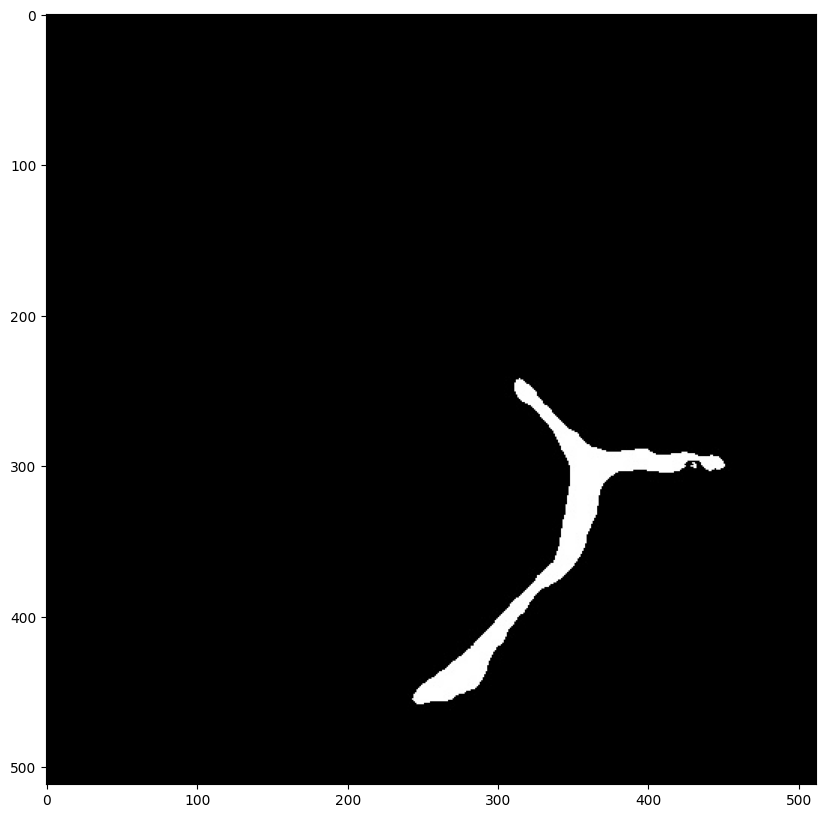

Isotropic closing of segmentation image


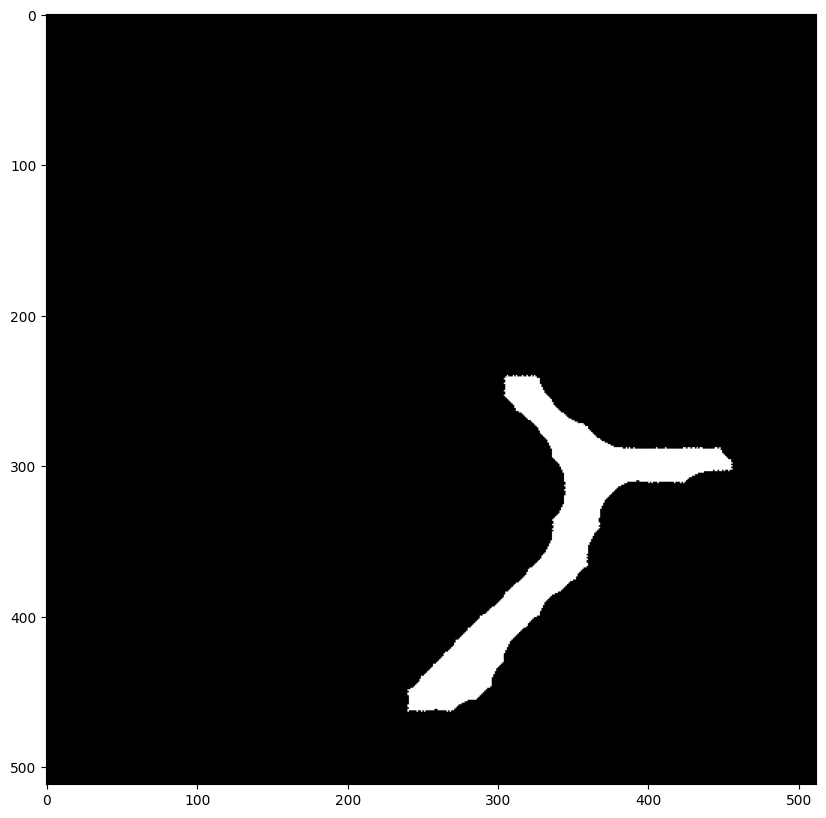

Number of contours: 1
Contour length: 836.7148560285568
Contour area: 8848.0
Convex hull area: 23393.5
Getting the skeleton
Getting intersections in skeleton (more than 2 neighbours)


Skeleton intersections = [(302, 360)]
Solidity = 0.3782247205420309 -> this contour can be related to an intersection in the road
Intersections = [(302, 360)]


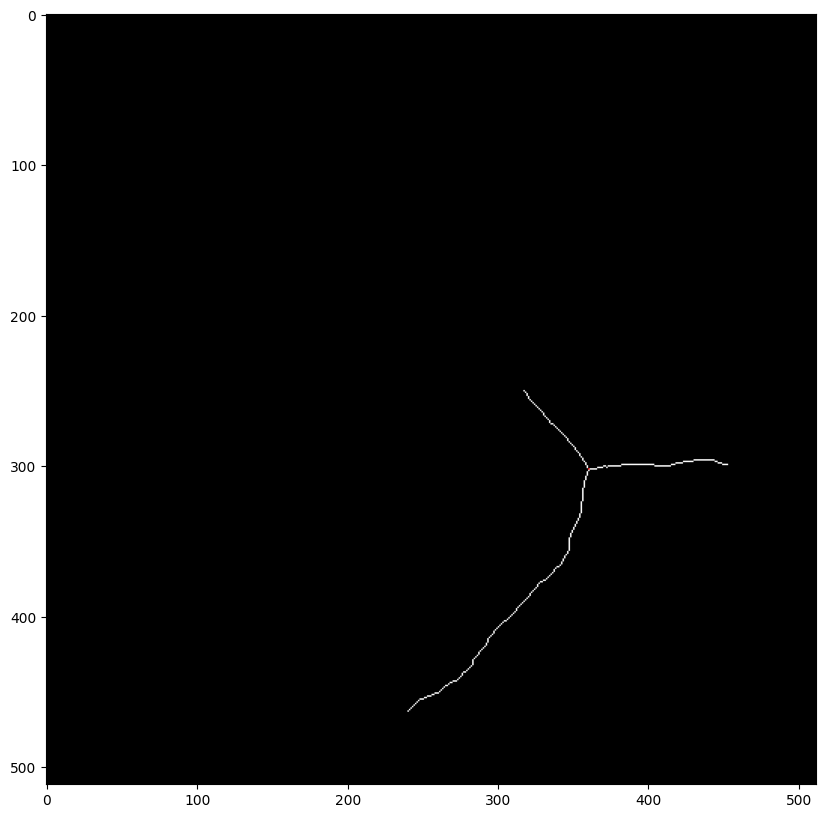

Angle is: 126.50144112050629
Angle is: 253.05077576617856
Angle is: 11.309932474020215
Array of descriptors: [[11.309932474020215, 126.50144112050629, 253.05077576617856]]


In [29]:
# segm_img_des = find_descriptors_in_segmentation_image(sem_segm_img_path)
segm_img_des = find_descriptors_in_segmentation_image(sem_segm_img_path) # without pruning
print(f"Array of descriptors: {segm_img_des}")

In [30]:
def find_descriptors_in_mapbox_image(img_path, image_name, vis=False) : 
    img_bgr = cv2.imread(img_path)
    # print("Mapbox image")
    # plot_image(img_bgr)

    new_width, new_height = img_bgr.shape[1], img_bgr.shape[0] - 100 
    cropped_img_bgr = img_bgr[0:new_height, 0:new_width]
    print("Cropped mapbox image")
    if vis : 
        plot_image(cropped_img_bgr)

    print("Binary thresholding")
    img_gray = cv2.cvtColor(cropped_img_bgr, cv2.COLOR_BGR2GRAY)
    ret, thresh_gray = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
    thresh_bgr = cv2.cvtColor(thresh_gray, cv2.COLOR_GRAY2BGR)
    if vis :
        plot_image(thresh_bgr)

    closing_bgr = isotropic_closing(thresh_bgr, radius=3)
    closing_bgr = closing_bgr.astype(np.uint8) * 255
    closing_gray = cv2.cvtColor(closing_bgr, cv2.COLOR_BGR2GRAY)
    print("Isotropic closing of segmentation image")
    if vis : 
        plot_image(closing_bgr)

    # To avoid the precision loss when converting the image to bool, 
    # you can also binarize the image using one of the available thresholding algorithms
    thresh_otsu = threshold_otsu(closing_gray)
    mask_gray = closing_gray > thresh_otsu
    
    # Skeletonize
    # skeleton_gray = (skeletonize(contour_mask_gray)).astype(np.uint8)
    skeleton_gray = skeletonize(mask_gray, method='lee').astype(np.uint8)

    skeleton_bgr = cv2.cvtColor(skeleton_gray, cv2.COLOR_GRAY2BGR)
    
    # find the intersections in the skeleton
    skel_intersections = get_skeleton_intersection(skeleton_bgr)

    print(f"{len(skel_intersections)} intersections found in the skeleton:")
    print(skel_intersections)

    descriptors = []
            
    #  if there are intersections
    if skel_intersections != [] :
        # visualization
        skeleton_bgr_copy = skeleton_bgr.copy()
        for intersection in skel_intersections :
            skeleton_bgr_copy[intersection[0], intersection[1]] = [0, 0, 255]

        if vis : 
            plot_image(skeleton_bgr_copy)


        print(f"There are intersections in mapbox image {image_name}")
        descriptors = get_descriptors(skeleton_bgr, skel_intersections, visualize = vis)   
    else :
        print("No intersections found in the skeleton")
        
    if descriptors == [] :
        return None
    else :
        return descriptors

**************************************************
Mapbox image: 50.8465495_3.6435285.jpg
**************************************************


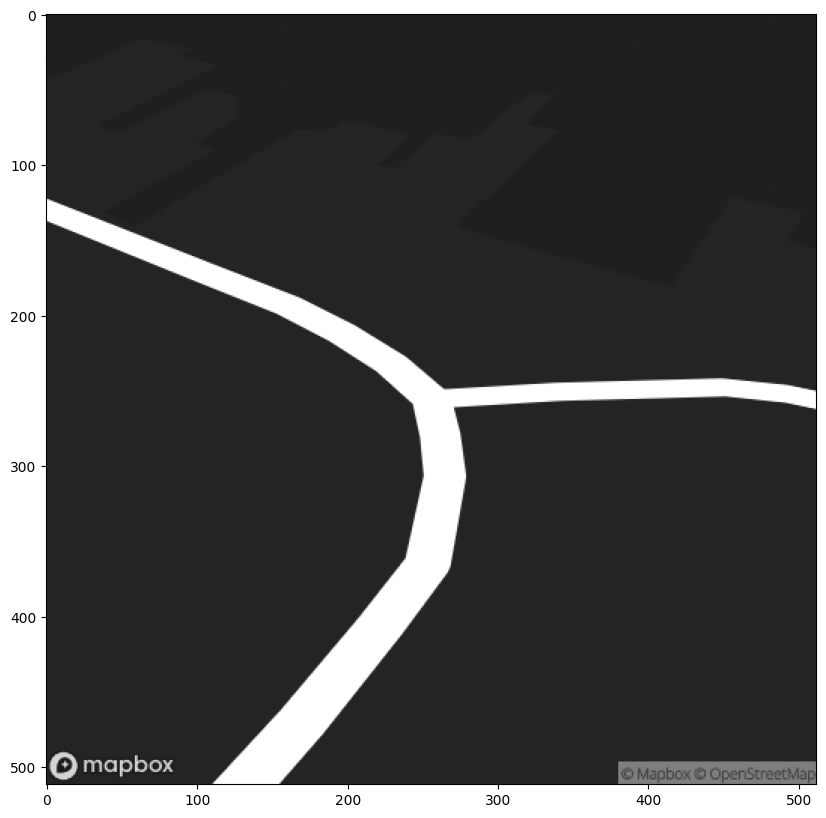

Cropped mapbox image


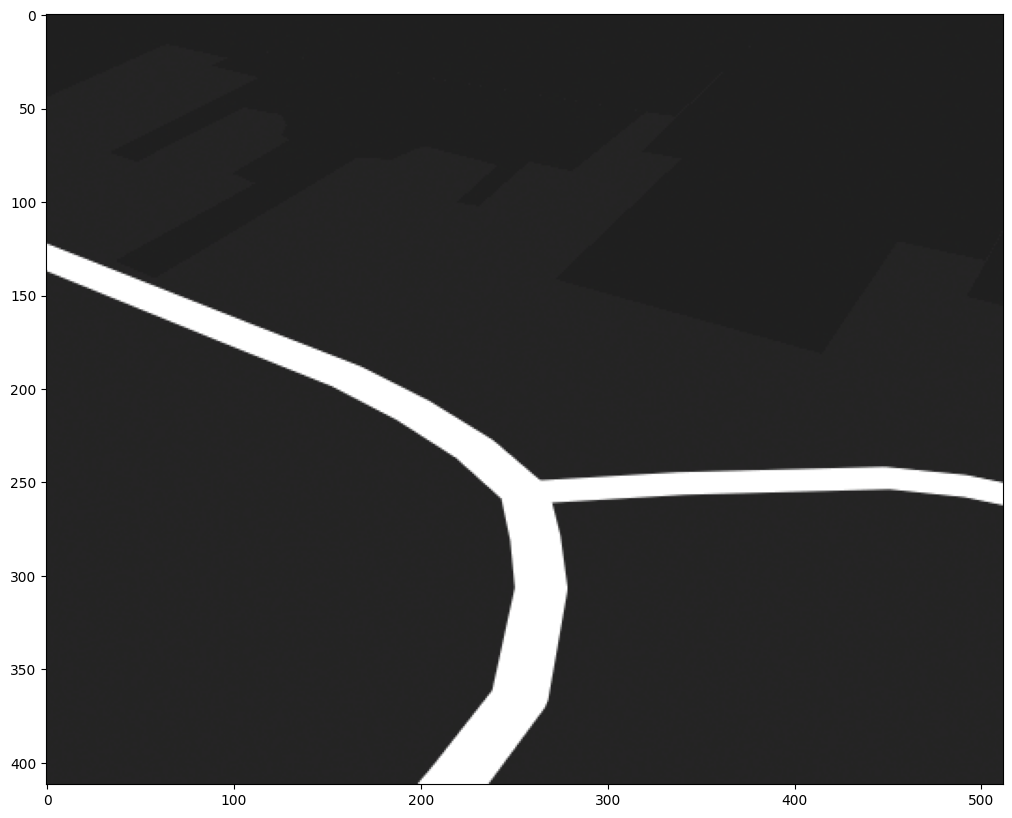

Binary thresholding


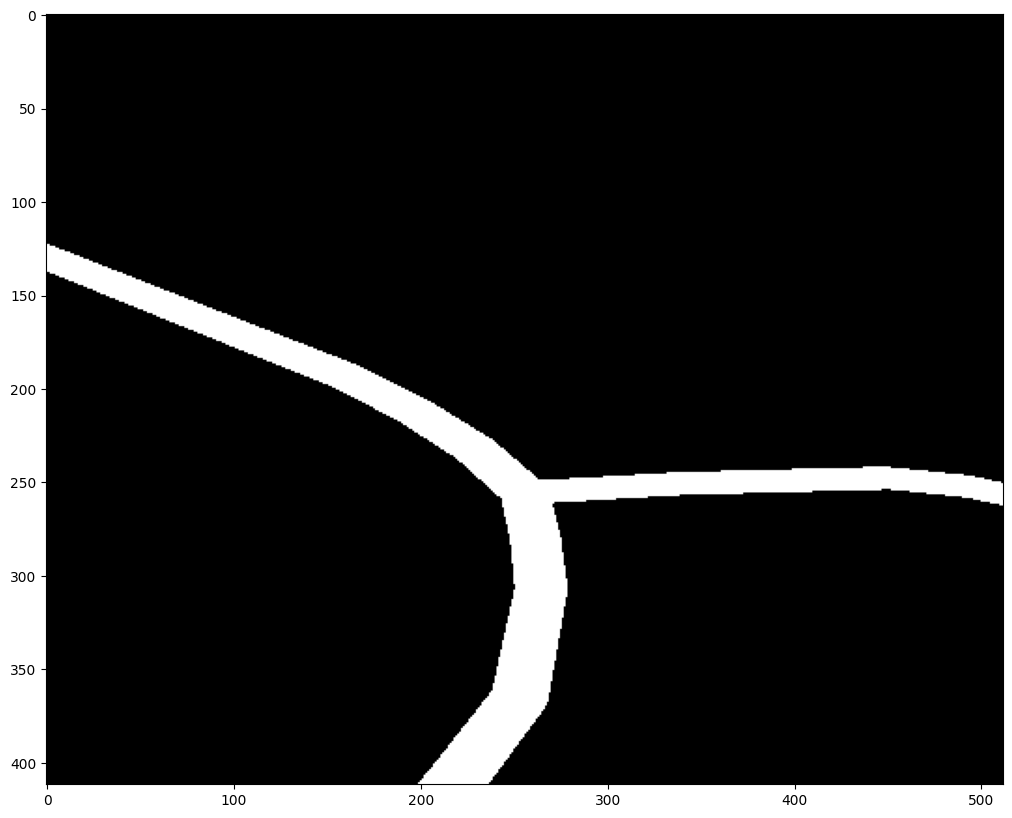

Isotropic closing of segmentation image


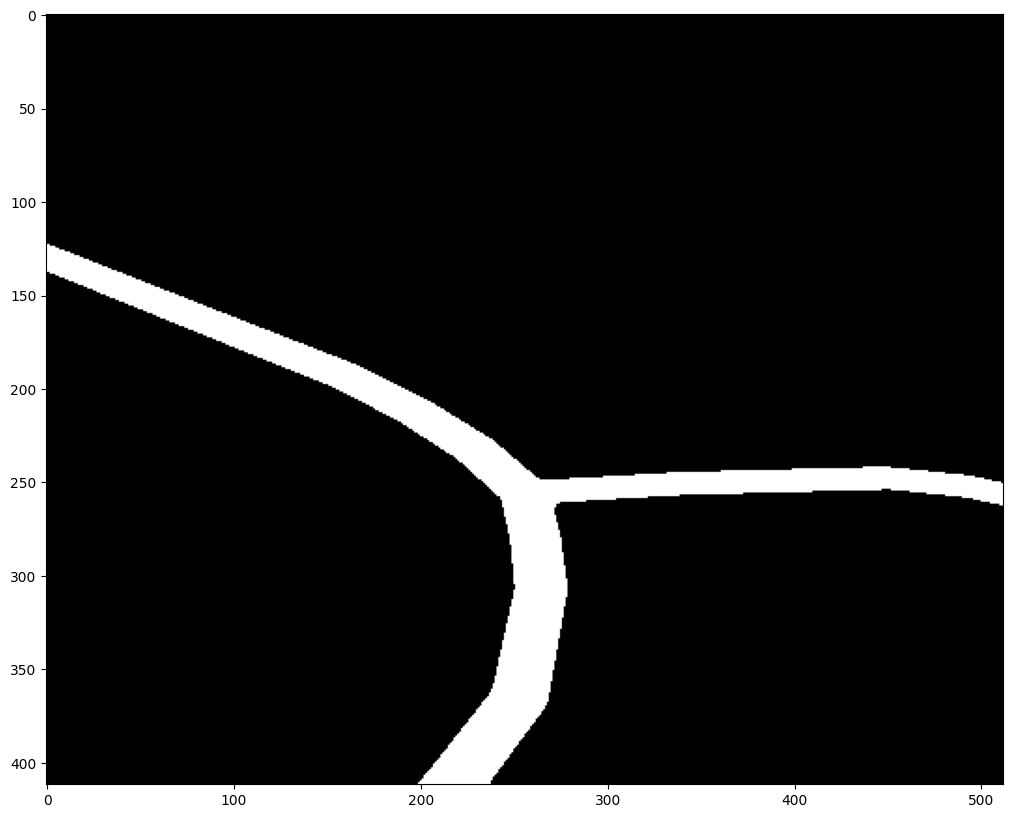

Getting intersections in skeleton (more than 2 neighbours)
1 intersections found in the skeleton:
[(262, 259)]


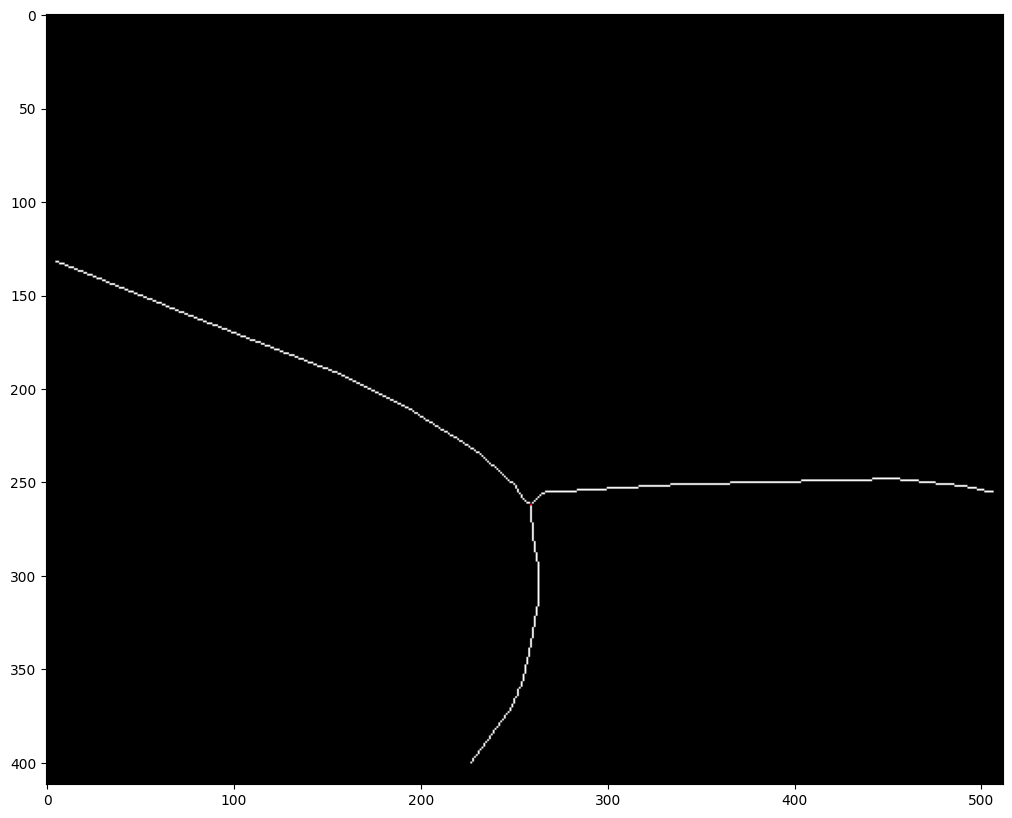

There are intersections in mapbox image 50.8465495_3.6435285.jpg


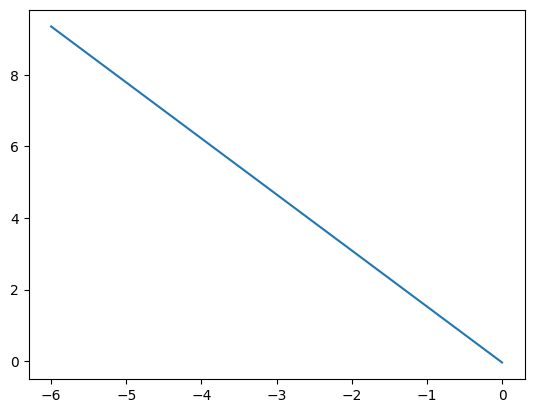

Angle is: 122.57186248258319


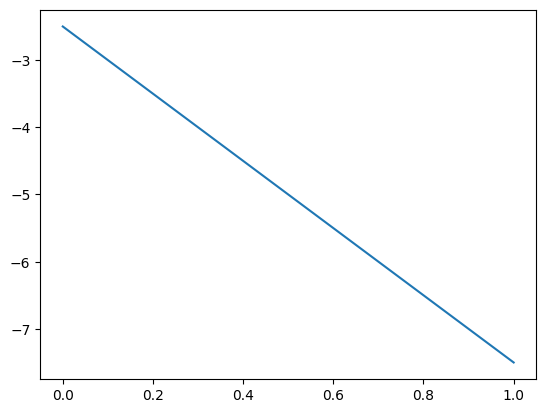

Angle is: 281.30993247402023


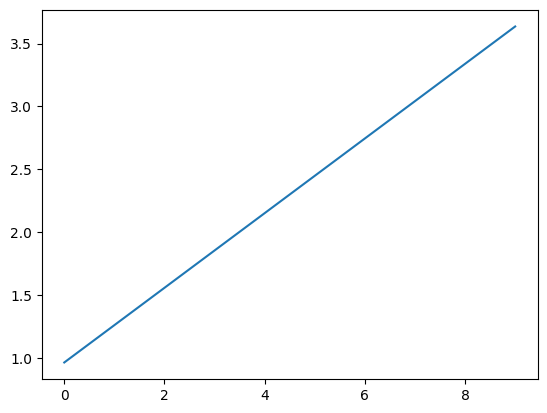

Angle is: 16.539824001228933
Descriptors for mapbox image 50.8465495_3.6435285.jpg:
[[16.539824001228933, 122.57186248258319, 281.30993247402023]]
Number of descriptors: 1
Descriptor of segmentation image:
[11.309932474020215, 126.50144112050629, 253.05077576617856]
Descriptor of mapbox image:
[16.539824001228933, 122.57186248258319, 281.30993247402023]
Result = 29.0064353462528
Score = 5.385762280889568
**************************************************
Mapbox image: 50.8455099_3.6426846.jpg
**************************************************


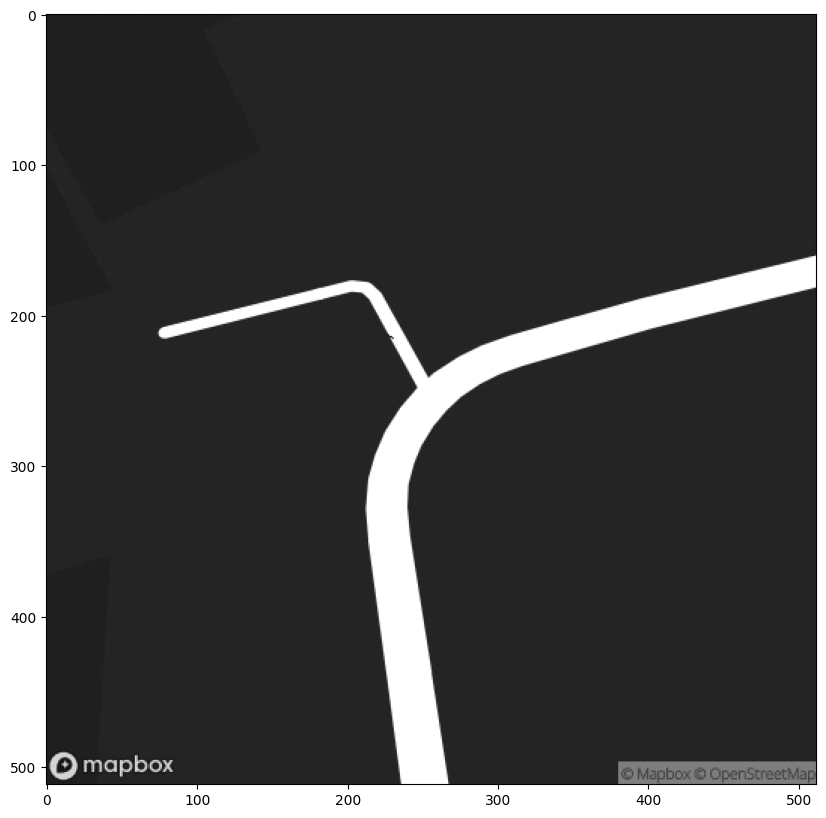

Cropped mapbox image


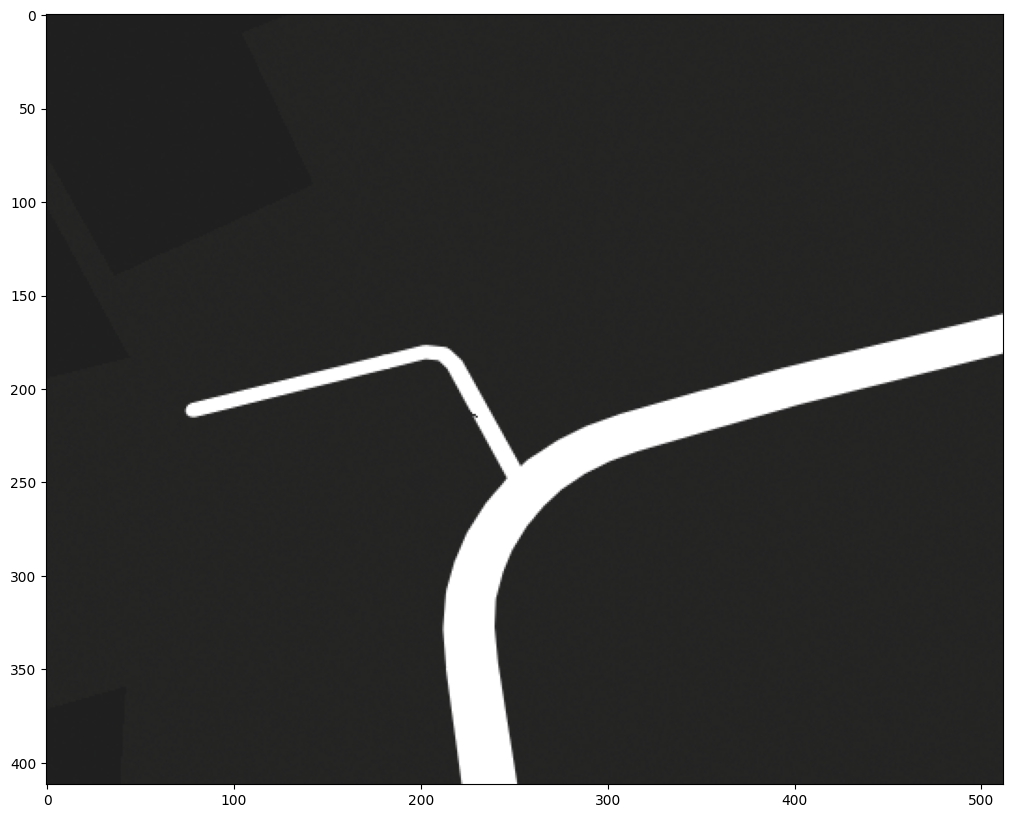

Binary thresholding


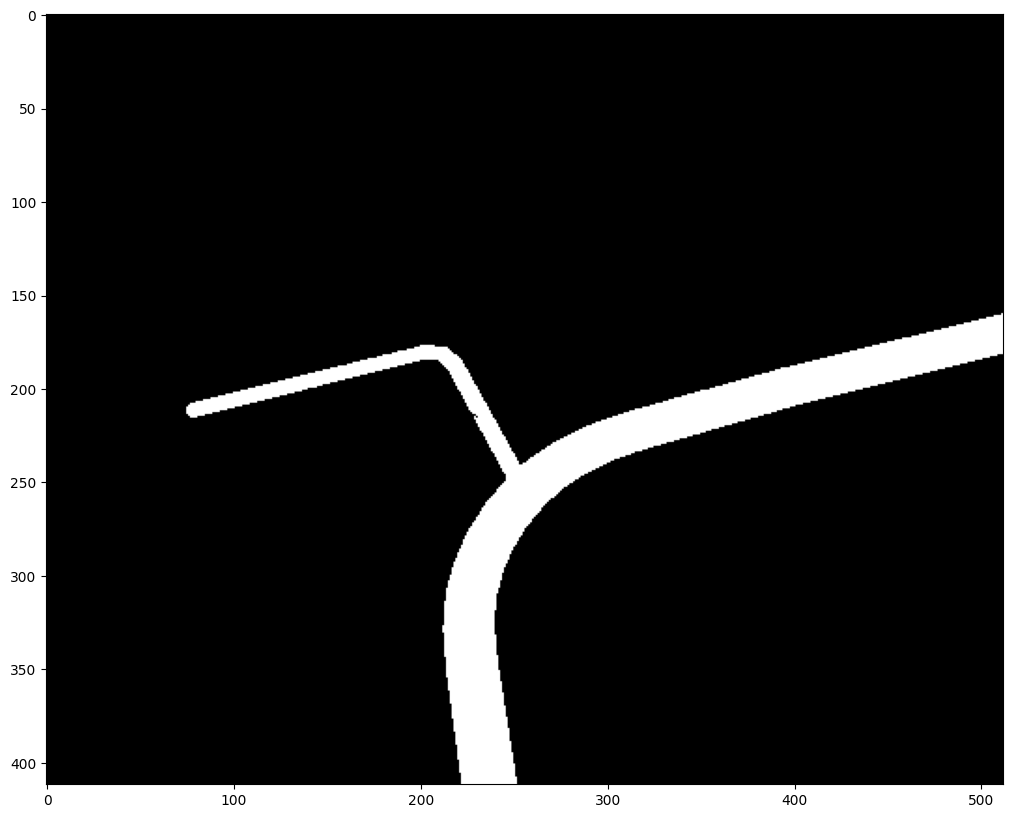

Isotropic closing of segmentation image


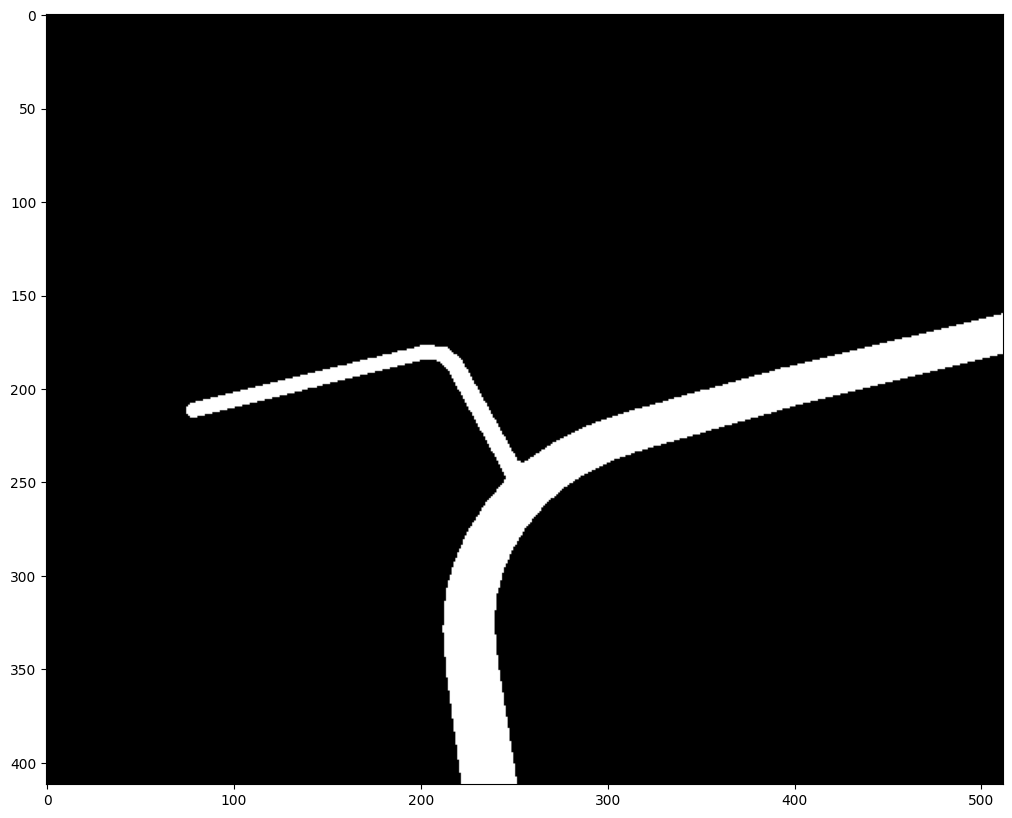

Getting intersections in skeleton (more than 2 neighbours)
1 intersections found in the skeleton:
[(251, 257)]


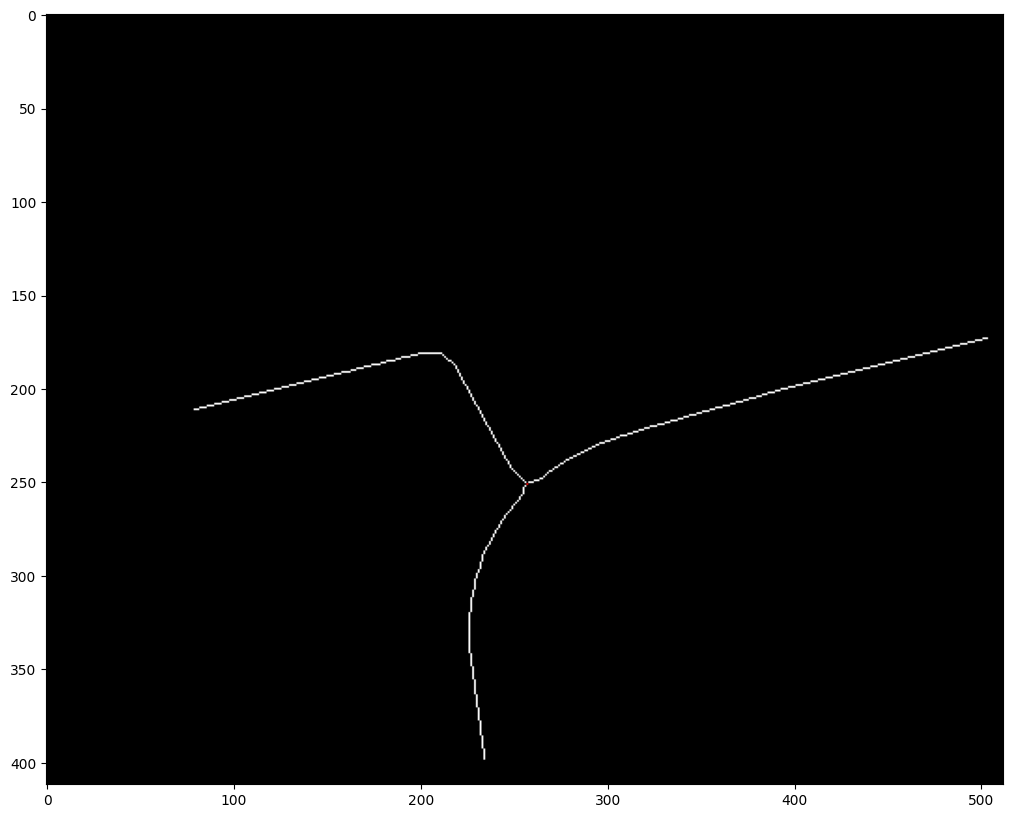

There are intersections in mapbox image 50.8455099_3.6426846.jpg


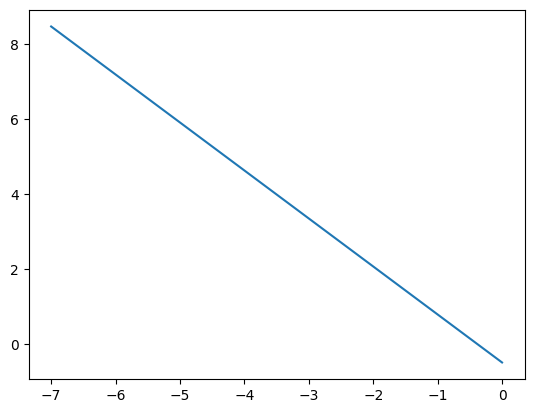

Angle is: 128.03962624250568


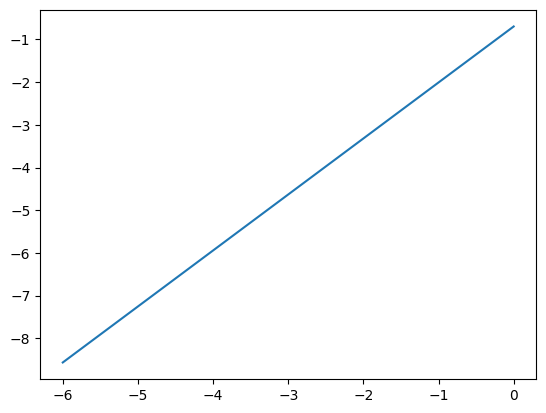

Angle is: 232.67079769477607


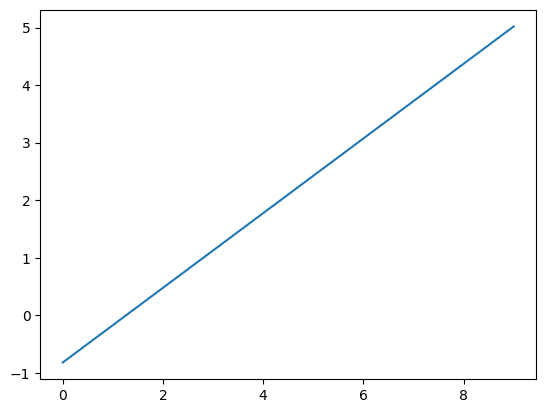

Angle is: 32.96279767963425
Descriptors for mapbox image 50.8455099_3.6426846.jpg:
[[32.96279767963425, 128.03962624250568, 232.67079769477607]]
Number of descriptors: 1
Descriptor of segmentation image:
[11.309932474020215, 126.50144112050629, 253.05077576617856]
Descriptor of mapbox image:
[32.96279767963425, 128.03962624250568, 232.67079769477607]
Result = 29.77509179285393
Score = 5.456655733400627
**************************************************
Mapbox image: 50.8433055_3.6459965.jpg
**************************************************


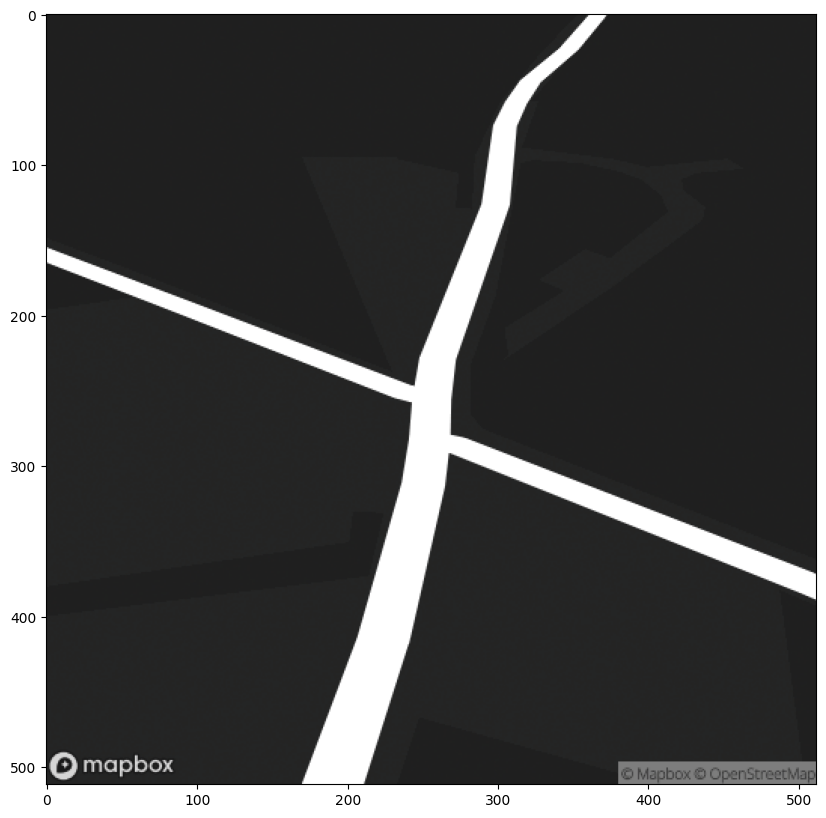

Cropped mapbox image


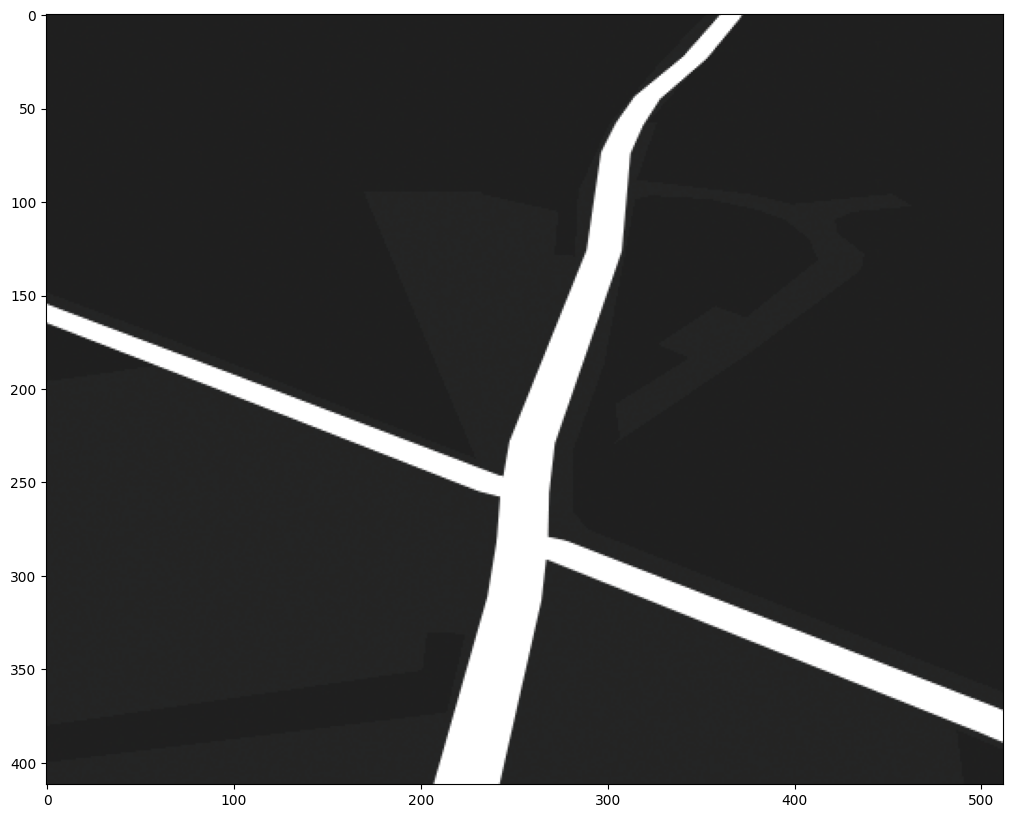

Binary thresholding


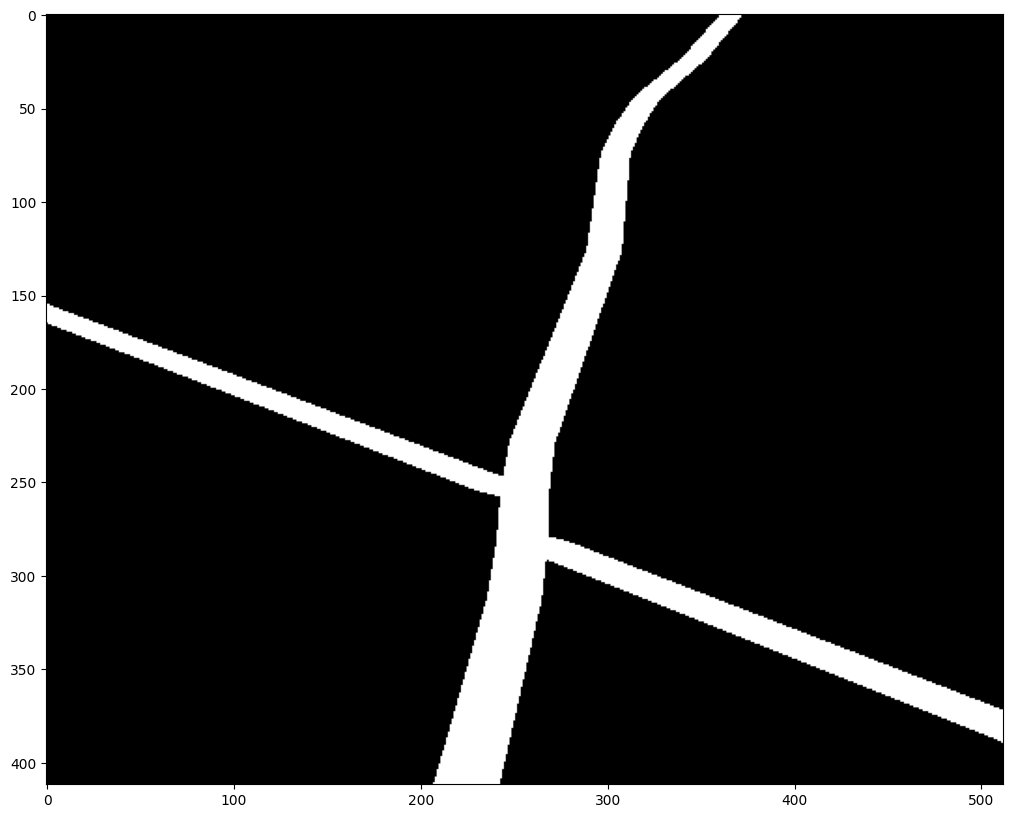

Isotropic closing of segmentation image


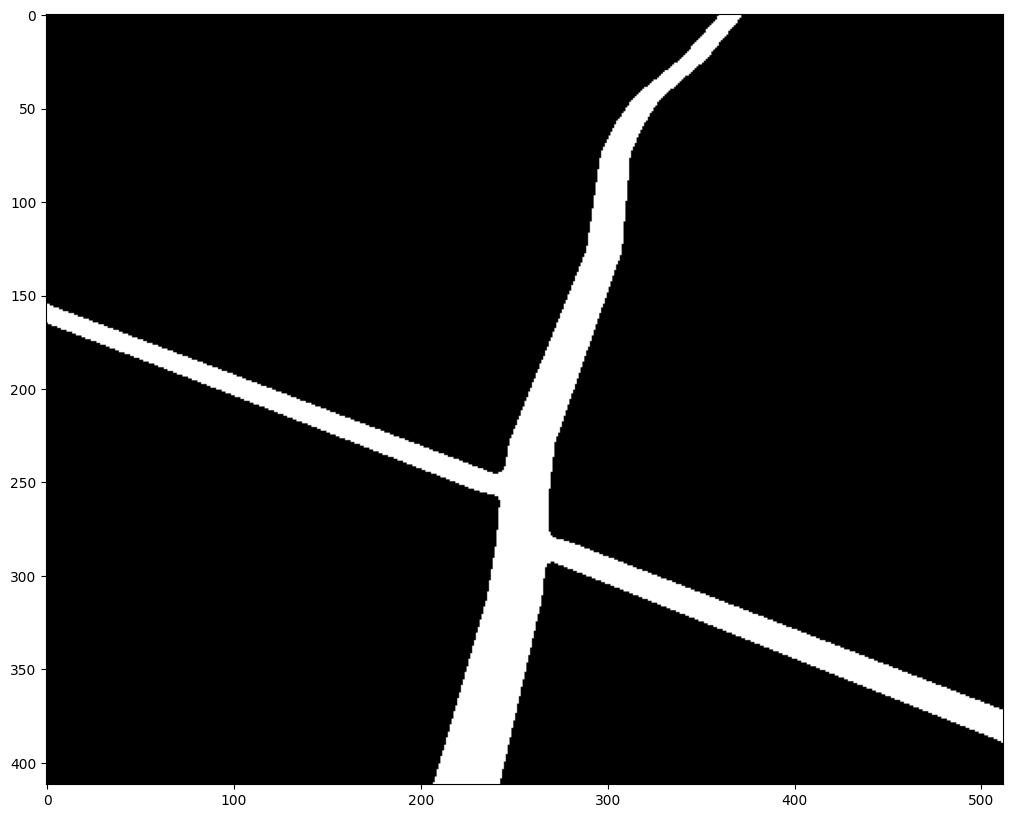

Getting intersections in skeleton (more than 2 neighbours)
2 intersections found in the skeleton:
[(258, 255), (280, 255)]


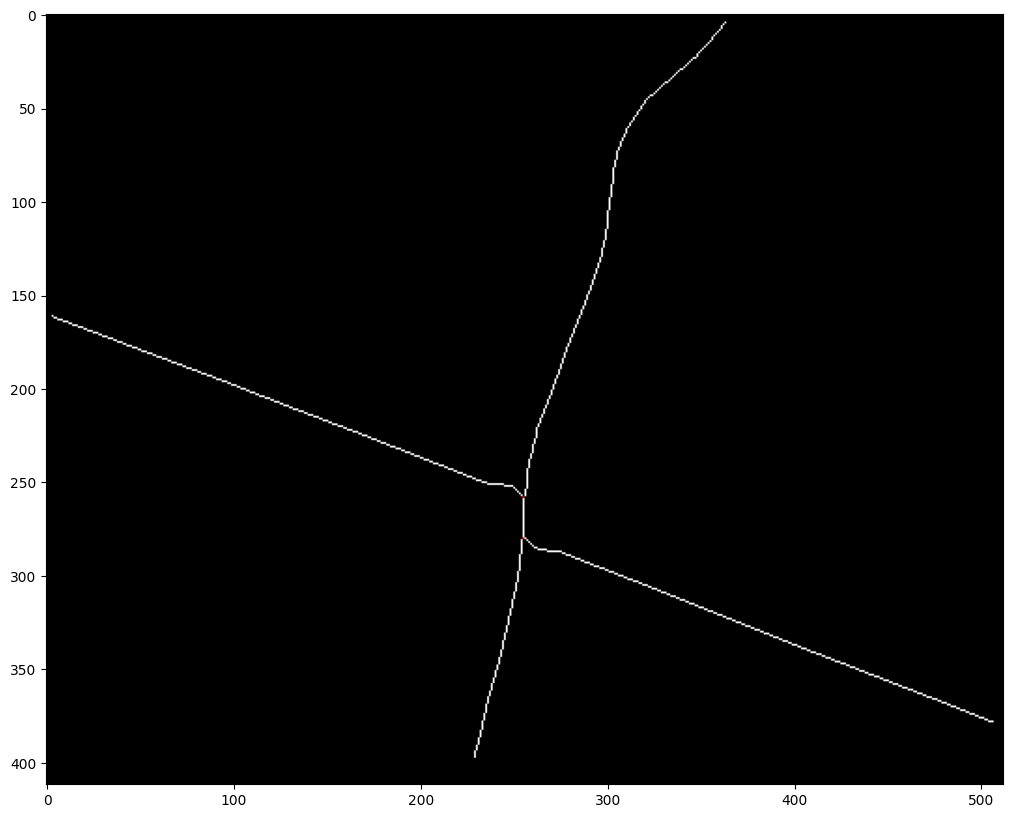

There are intersections in mapbox image 50.8433055_3.6459965.jpg


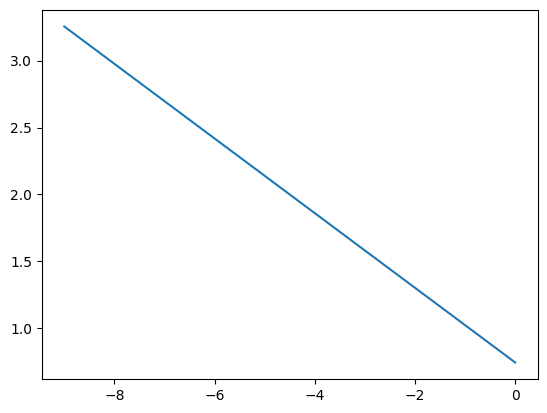

Angle is: 164.42217422568896
All x-values are the same
Angle is: 270


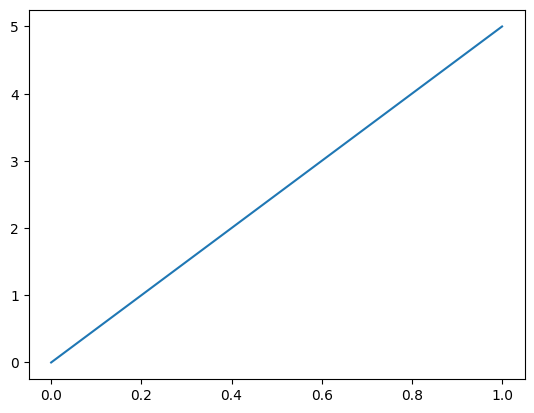

Angle is: 78.69006752597979


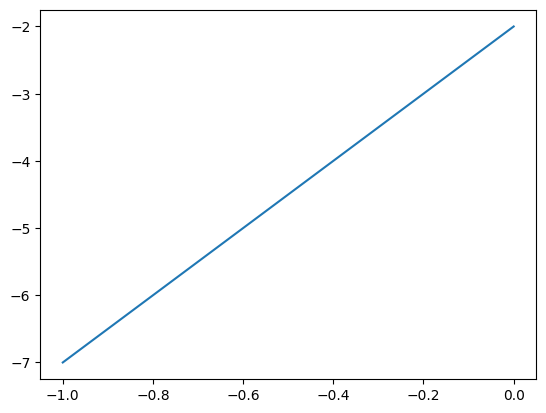

Angle is: 258.69006752597977
All x-values are the same
Angle is: 90


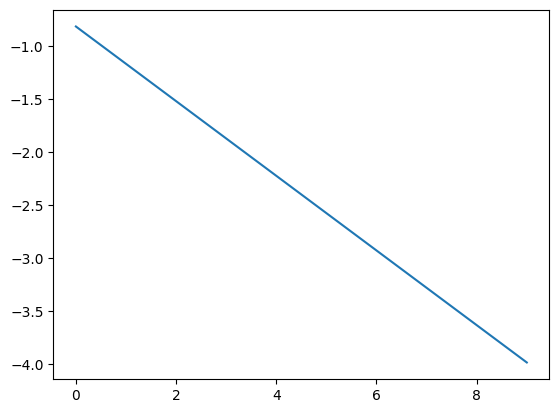

Angle is: 340.63265245222374
Descriptors for mapbox image 50.8433055_3.6459965.jpg:
[[78.69006752597979, 164.42217422568896, 270], [90, 258.69006752597977, 340.63265245222374]]
Number of descriptors: 2
Descriptor of segmentation image:
[11.309932474020215, 126.50144112050629, 253.05077576617856]
Descriptor of mapbox image:
[78.69006752597979, 164.42217422568896, 270]
Result = 79.15390578476318
Descriptor of mapbox image:
[90, 258.69006752597977, 340.63265245222374]
Result = 48.01304327952627
Score = 6.929144483955164
**************************************************
Mapbox image: 50.8431527_3.6440709.jpg
**************************************************


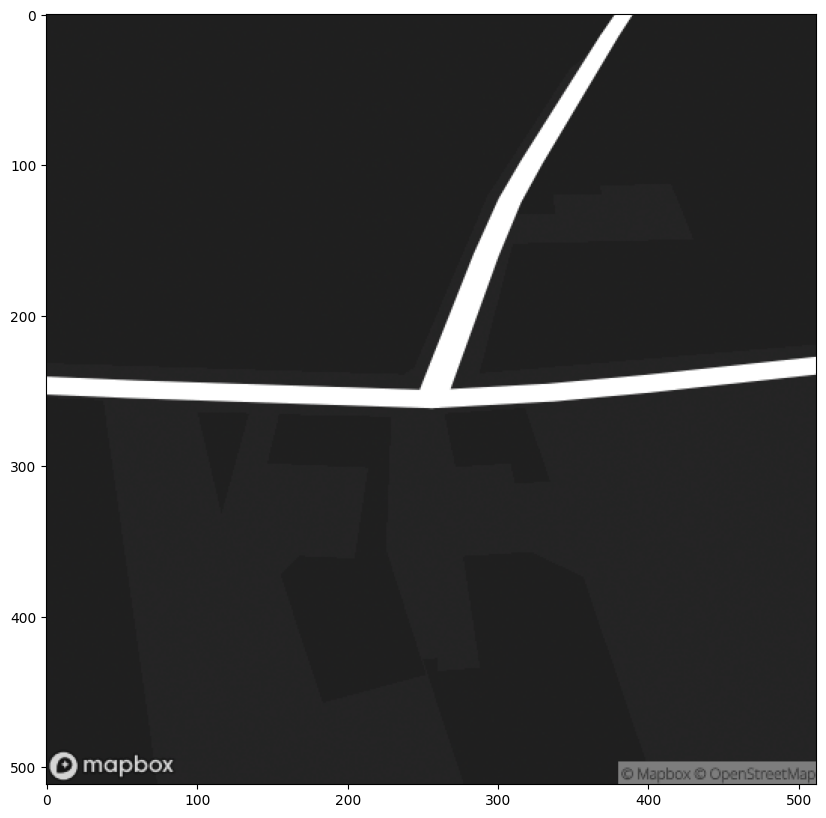

Cropped mapbox image


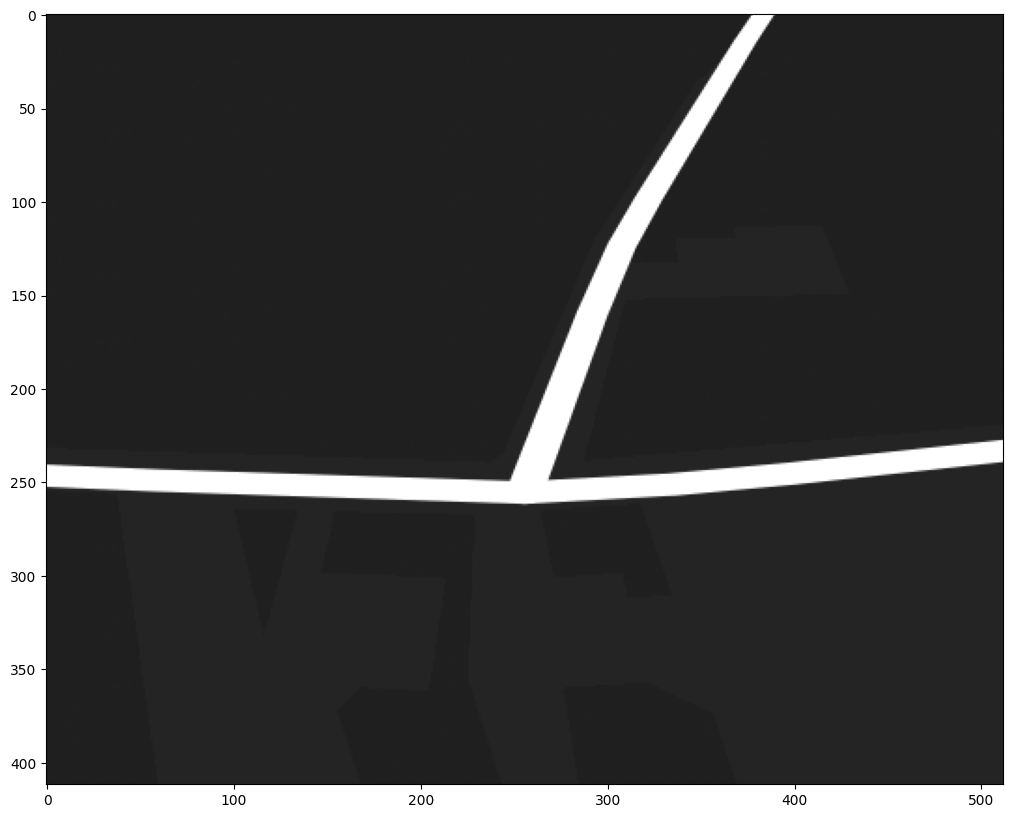

Binary thresholding


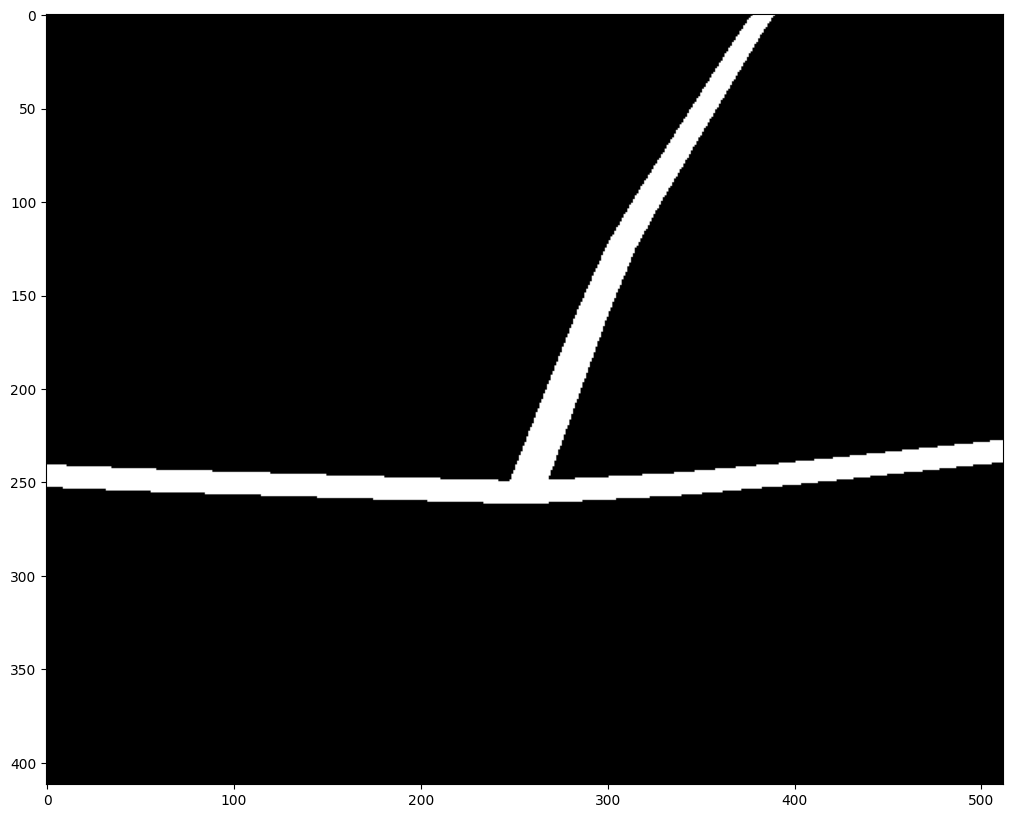

Isotropic closing of segmentation image


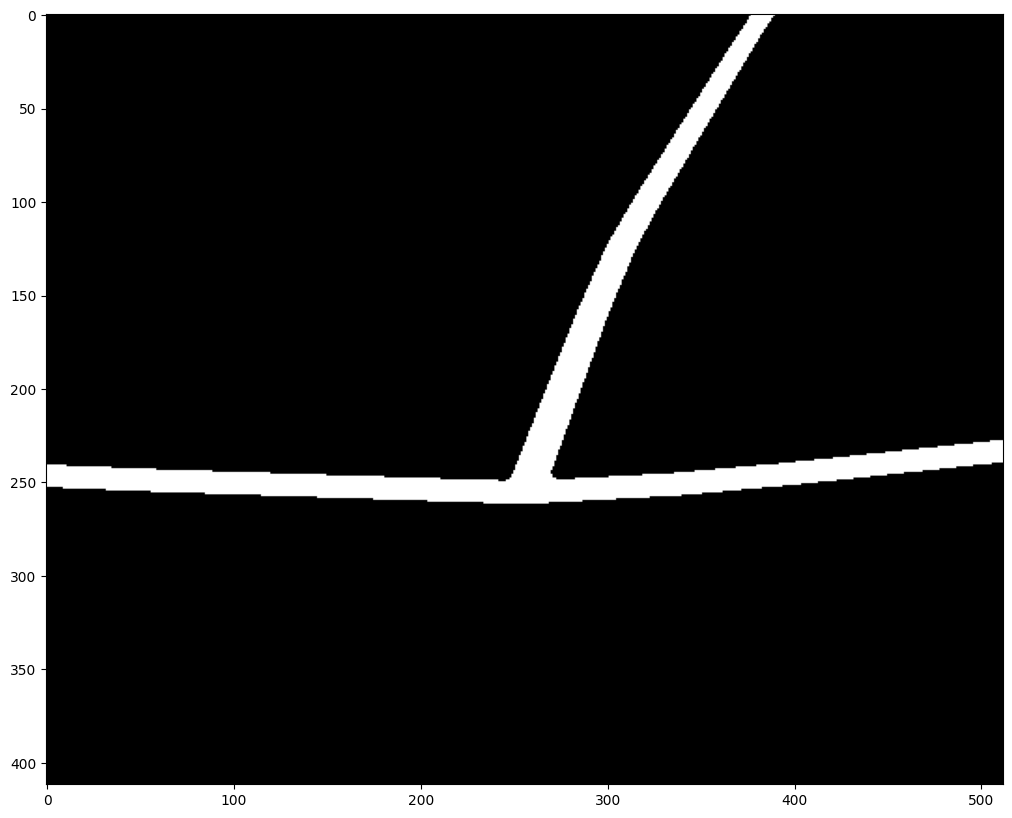

Getting intersections in skeleton (more than 2 neighbours)
1 intersections found in the skeleton:
[(251, 260)]


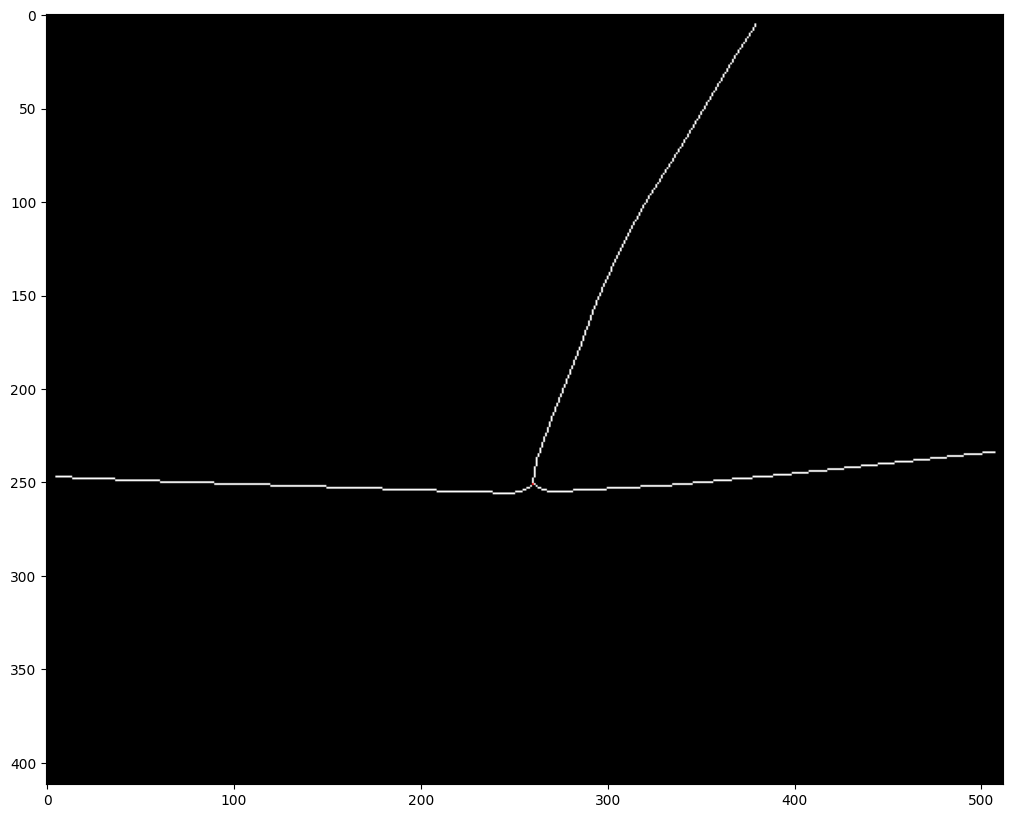

There are intersections in mapbox image 50.8431527_3.6440709.jpg


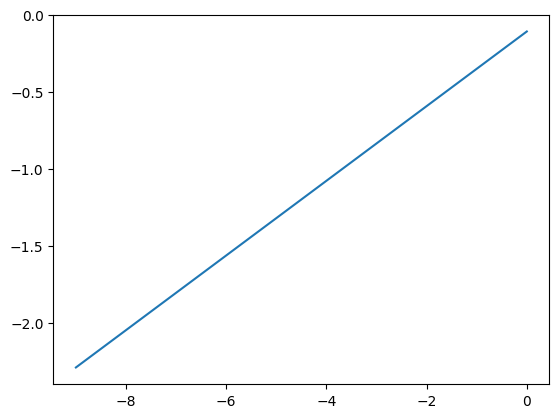

Angle is: 193.62699485989154


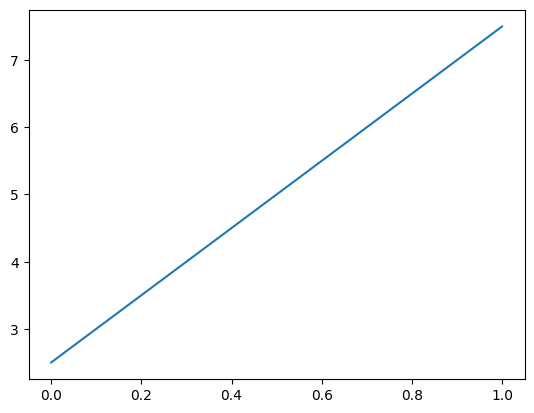

Angle is: 78.69006752597979


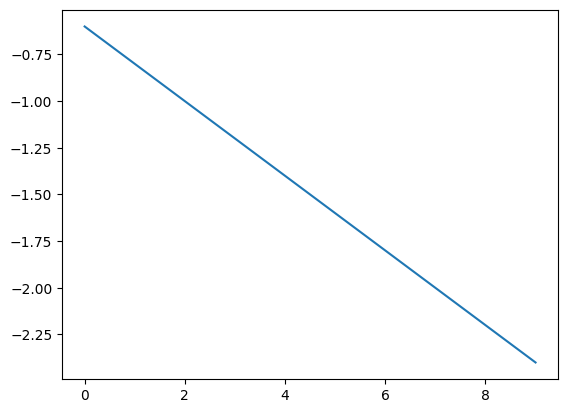

Angle is: 348.69006752597977
Descriptors for mapbox image 50.8431527_3.6440709.jpg:
[[78.69006752597979, 193.62699485989154, 348.69006752597977]]
Number of descriptors: 1
Descriptor of segmentation image:
[11.309932474020215, 126.50144112050629, 253.05077576617856]
Descriptor of mapbox image:
[78.69006752597979, 193.62699485989154, 348.69006752597977]
Result = 79.5535761135939
Score = 8.919281143320571
**************************************************
Mapbox image: 50.8433633_3.6459059.jpg
**************************************************


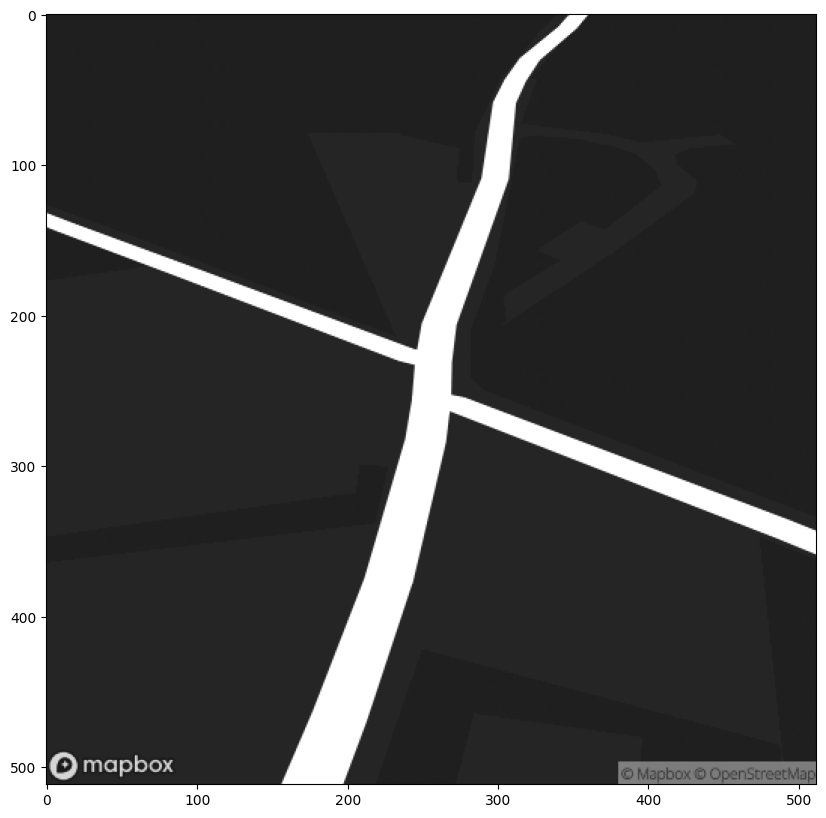

Cropped mapbox image


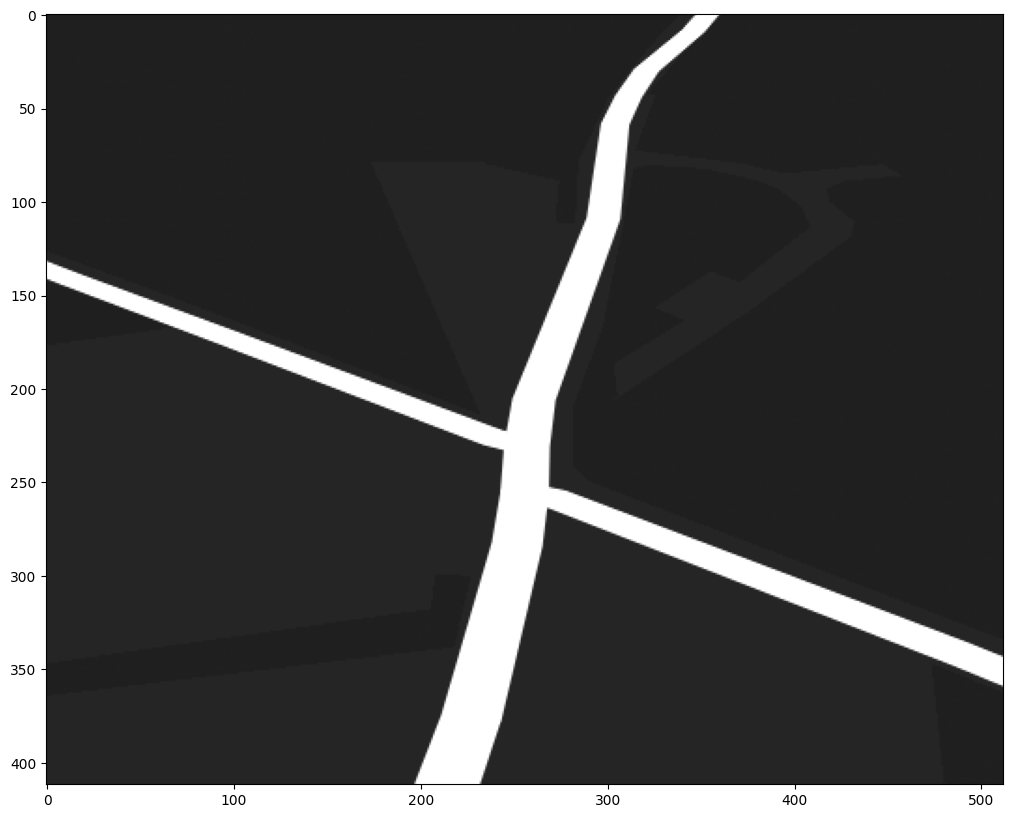

Binary thresholding


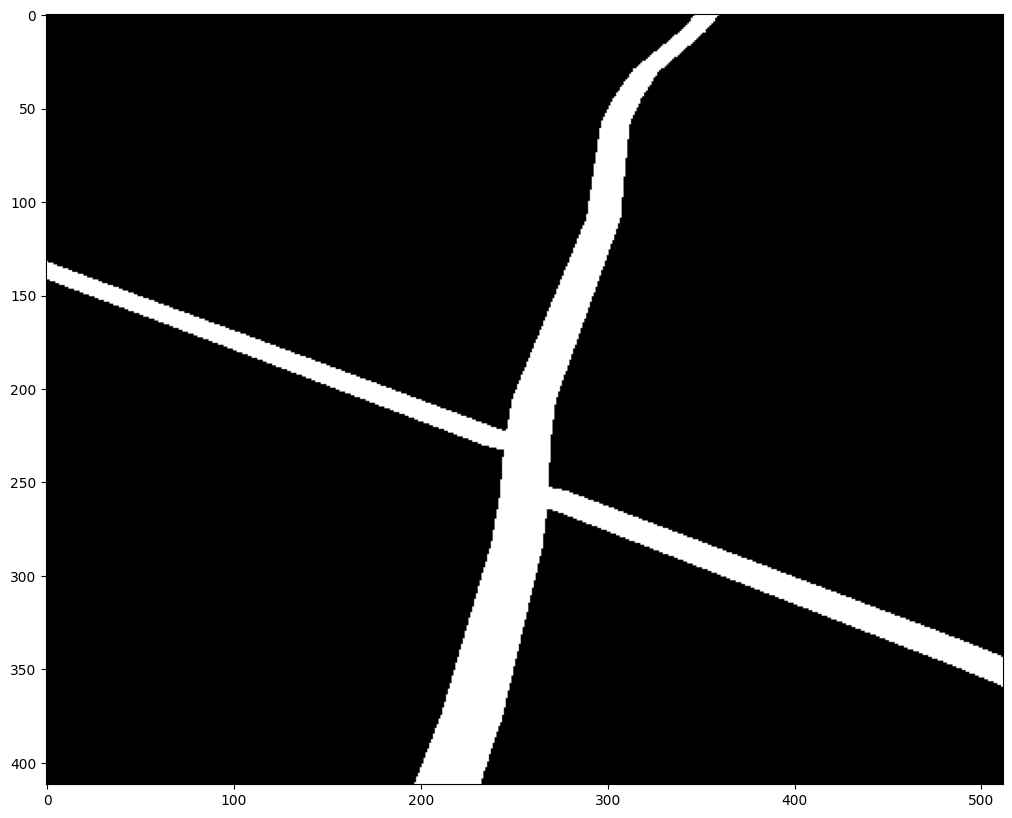

Isotropic closing of segmentation image


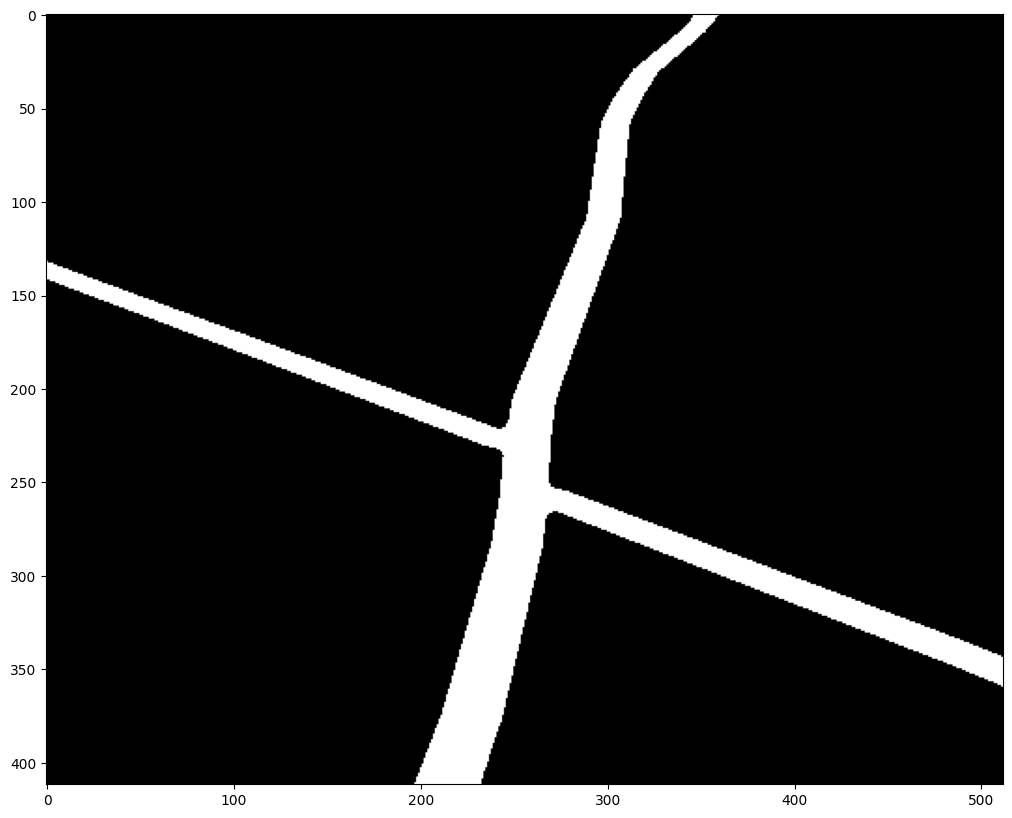

Getting intersections in skeleton (more than 2 neighbours)
2 intersections found in the skeleton:
[(233, 256), (255, 256)]


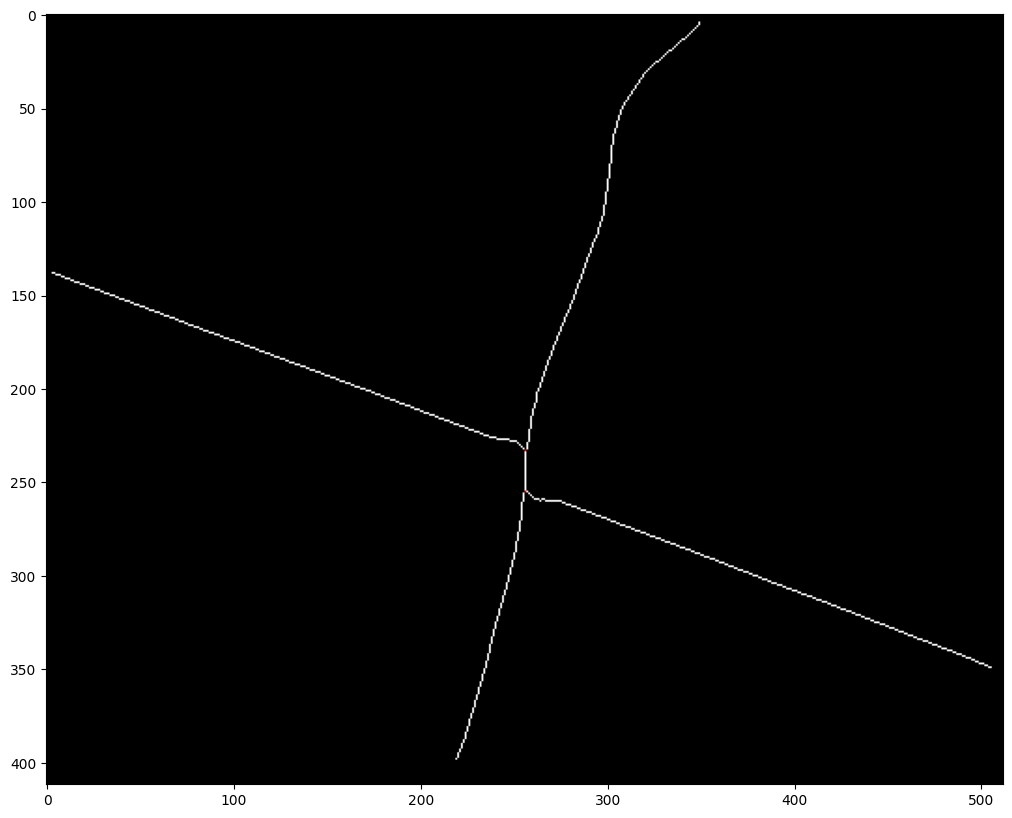

There are intersections in mapbox image 50.8433633_3.6459059.jpg


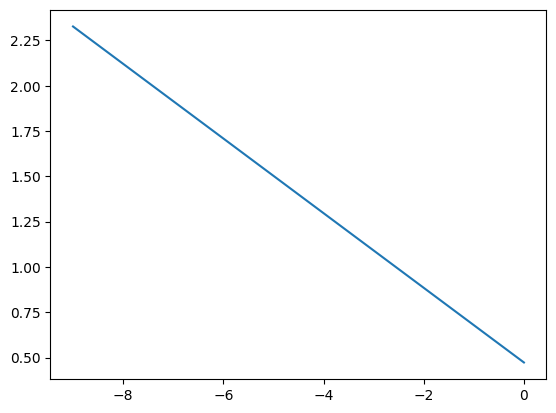

Angle is: 168.3565685012383
All x-values are the same
Angle is: 270


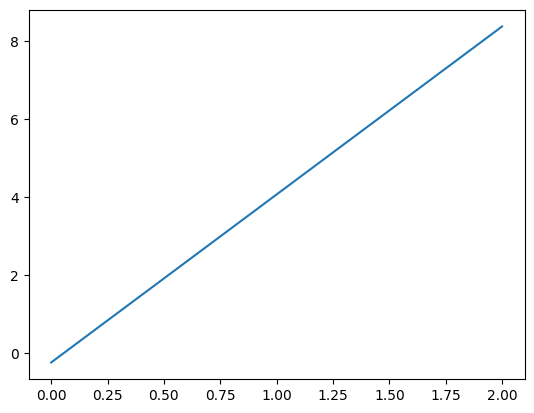

Angle is: 76.93844891667189


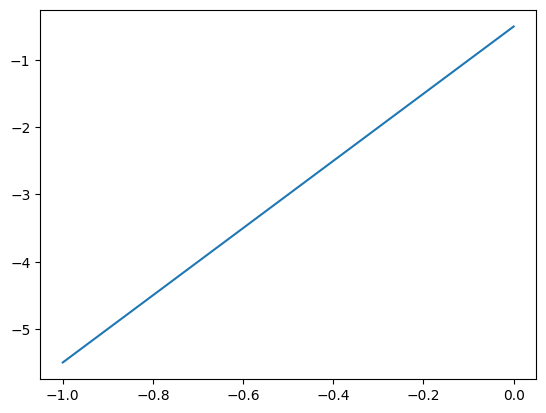

Angle is: 258.69006752597977
All x-values are the same
Angle is: 90


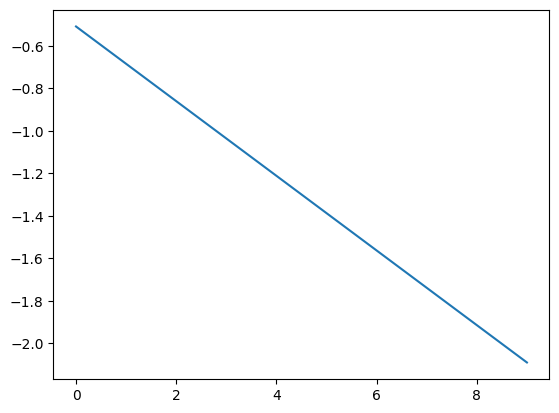

Angle is: 350.03164382952616
Descriptors for mapbox image 50.8433633_3.6459059.jpg:
[[76.93844891667189, 168.3565685012383, 270], [90, 258.69006752597977, 350.03164382952616]]
Number of descriptors: 2
Descriptor of segmentation image:
[11.309932474020215, 126.50144112050629, 253.05077576617856]
Descriptor of mapbox image:
[76.93844891667189, 168.3565685012383, 270]
Result = 79.66322903729842
Descriptor of mapbox image:
[90, 258.69006752597977, 350.03164382952616]
Result = 42.62537252698625
Score = 6.528810958129072
Scores: {'50.8465495_3.6435285.jpg': 5.385762280889568, '50.8455099_3.6426846.jpg': 5.456655733400627, '50.8433055_3.6459965.jpg': 6.929144483955164, '50.8431527_3.6440709.jpg': 8.919281143320571, '50.8433633_3.6459059.jpg': 6.528810958129072}
**************************************************
Top 3 results:
**************************************************
Score = 5.385762280889568 with mapbox image 50.8465495_3.6435285.jpg
Score = 5.456655733400627 with mapbox image 50.84

In [31]:
best_mb_image = None
scores = dict()
visualize = True 

for mb_image in os.listdir(mapbox_imgs_dir_path) : 
    best_results = []
    mb_image_path = os.path.join(mapbox_imgs_dir_path, mb_image)
    print(50*"*")
    print(f"Mapbox image: {mb_image}")
    print(50*"*")
    mb_image_bgr = cv2.imread(mb_image_path)
    if visualize : 
        plot_image(mb_image_bgr)
    des = find_descriptors_in_mapbox_image(mb_image_path, mb_image, vis=visualize)
    print(f"Descriptors for mapbox image {mb_image}:")
    print(des)

    # matching process
    if des is not None and segm_img_des is not None :
        print(f"Number of descriptors: {len(des)}")
        for des_segm in segm_img_des :
            best_result_per_des = 1000 # best descriptor match for descriptor des_segm of segmentation image
            print(f"Descriptor of segmentation image:")
            print(des_segm)
            for des_mb in des :
                print(f"Descriptor of mapbox image:")
                print(des_mb)

                if len(des_mb) < len(des_segm) : 
                    continue

                result = 0
                for angle_des_segm in des_segm : 
                    best_diff = 1000
                    for angle_des_mb in des_mb :
                        diff = min(abs(angle_des_segm-angle_des_mb), abs((angle_des_segm+360)-angle_des_mb), abs((angle_des_mb+360)-angle_des_segm))
                        if diff < best_diff :
                            best_diff = diff
                    result += best_diff**2
                
                
                result = math.sqrt(result)
                print(f"Result = {result}")
            
                if result < best_result_per_des :
                    best_result_per_des = result

            best_results.append(best_result_per_des)
        
        score =  math.sqrt(np.sum(best_results))
        print(f"Score = {score}")
        
        # make sure there is at least one best result that is below the threshold 
        threshold = 40

        # If at least one result is below the threshold, add the score to the dictionary
        # if any(result < threshold for result in best_results) :
        #   print(f"At least one result is below the threshold, add the score to the dictionary for mapbox image {mb_image}")
        #   scores[mb_image] = score
        scores[mb_image] = score
    else:
        continue


print(f"Scores: {scores}")
# Get the lowest three values using sorted() and dictionary items()
lowest_values = sorted(scores.values())[:3]
print(50*"*")
print("Top 3 results:")
print(50*"*")
for value in lowest_values:
    # For each value, get the corresponding key
    for key in scores.keys():
        if scores[key] == value:
            print(f"Score = {value} with mapbox image {key}")